# Pathfinding Algorithm Comparison Analysis

This notebook provides a comprehensive statistical analysis and visualization of different pathfinding algorithms (A*, Dijkstra, Breadth-First, Theta*) across various test cases with different start-to-end distances.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, shapiro
import warnings
import os
from datetime import datetime
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set figure size for better visibility
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Define consistent color mapping for algorithms
ALGORITHM_COLORS = {
    'A*': '#1f77b4',           # Blue
    'Dijkstra': '#ff7f0e',     # Orange
    'Breadth-First': '#2ca02c', # Green
    'Theta*': '#d62728'        # Red
}

# Create color list for easy access
algorithm_color_list = [ALGORITHM_COLORS[algo] for algo in ['A*', 'Dijkstra', 'Breadth-First', 'Theta*']]

# Create output directory for saving plots
output_dir = f"algorithm_analysis_plots_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}")
else:
    print(f"Using existing output directory: {output_dir}")

# Function to save plots
def save_plot(filename, dpi=300, bbox_inches='tight'):
    """Save the current plot to the output directory"""
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches, facecolor='white', edgecolor='none')
    print(f"Saved: {filepath}")
    return filepath


Created output directory: algorithm_analysis_plots_20250917_144437


## Data Loading and Preprocessing


In [2]:
# Load the data
try:
    df = pd.read_csv('pathfinding_comparison_results.csv')
except FileNotFoundError:
    print("Results file not found. Running algorithm comparison first...")
    import subprocess
    subprocess.run(['python', 'algorithm_comparison.py'])
    df = pd.read_csv('pathfinding_comparison_results.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

print("\n" + "="*60)
print("IMPORTANT DISTINCTION:")
print("="*60)
print("• euclidean_distance: Straight-line distance between start and end coordinates")
print("• path_length: Actual distance of the path found by the algorithm")
print("• path_efficiency: Ratio of euclidean_distance to path_length (lower is better)")
print("="*60)


Dataset Shape: (400, 15)

Column Names:
['test_case', 'start_x', 'start_y', 'start_z', 'end_x', 'end_y', 'end_z', 'euclidean_distance', 'algorithm', 'execution_time', 'operations', 'path_length', 'steps', 'success', 'path_efficiency']

First few rows:
   test_case  start_x  start_y  start_z  end_x  end_y  end_z  \
0          1       13        2        2     24      8     10   
1          1       13        2        2     24      8     10   
2          1       13        2        2     24      8     10   
3          1       13        2        2     24      8     10   
4          2       10        1        0     15     14      4   

   euclidean_distance      algorithm  execution_time  operations  path_length  \
0             14.8661             A*        0.001392          81      17.5851   
1             14.8661       Dijkstra        0.068608        6116      17.5851   
2             14.8661  Breadth-First        0.030579        4478      17.8742   
3             14.8661         Theta*   

In [3]:
# Create distance categories matching maze-generation buckets (4 groups)
# Short: test_case 1-20, Medium: 21-55, Long: 56-80, Very Long: 81-100
def categorize_distance_by_case(test_case):
    if 1 <= test_case <= 20:
        return 'Short'
    elif 21 <= test_case <= 55:
        return 'Medium'
    elif 56 <= test_case <= 80:
        return 'Long'
    else:
        return 'Very Long'

df['distance_category'] = df['test_case'].apply(categorize_distance_by_case)

# Display the distribution of distance categories
print("Distance Category Distribution (based on straight-line euclidean distance):")
print(df['distance_category'].value_counts())
print("\nDistance Category by Algorithm:")
print(pd.crosstab(df['algorithm'], df['distance_category']))

print("\n" + "="*60)
print("DISTANCE CATEGORY EXPLANATION (by generation buckets):")
print("="*60)
print("• Short: Test cases 1–20 (offsets ~5–15 per axis)")
print("• Medium: Test cases 21–55 (offsets ~15–30 per axis)") 
print("• Long: Test cases 56–80 (offsets ~30–40 per axis)")
print("• Very Long: Test cases 81–100 (diagonal/opposite regions)")
print("Note: Categories mirror how pairs were generated, not thresholds on euclidean_distance.")
print("="*60)


Distance Category Distribution (based on straight-line euclidean distance):
distance_category
Medium       140
Long         100
Short         80
Very Long     80
Name: count, dtype: int64

Distance Category by Algorithm:
distance_category  Long  Medium  Short  Very Long
algorithm                                        
A*                   25      35     20         20
Breadth-First        25      35     20         20
Dijkstra             25      35     20         20
Theta*               25      35     20         20

DISTANCE CATEGORY EXPLANATION (by generation buckets):
• Short: Test cases 1–20 (offsets ~5–15 per axis)
• Medium: Test cases 21–55 (offsets ~15–30 per axis)
• Long: Test cases 56–80 (offsets ~30–40 per axis)
• Very Long: Test cases 81–100 (diagonal/opposite regions)
Note: Categories mirror how pairs were generated, not thresholds on euclidean_distance.


## Basic Statistical Analysis


In [4]:
# Calculate comprehensive statistics for each algorithm
metrics = ['execution_time', 'operations', 'path_length', 'path_efficiency']

print("=== COMPREHENSIVE STATISTICAL ANALYSIS ===\n")

for metric in metrics:
    print(f"\n{'='*50}")
    print(f"ANALYSIS FOR: {metric.upper()}")
    print(f"{'='*50}")
    
    # Overall statistics
    stats_data = df.groupby('algorithm')[metric].agg([
        'count', 'mean', 'median', 'std', 'var', 'min', 'max',
        ('mode', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
        ('q25', lambda x: x.quantile(0.25)),
        ('q75', lambda x: x.quantile(0.75)),
        ('iqr', lambda x: x.quantile(0.75) - x.quantile(0.25))
    ]).round(4)
    
    print("\nOverall Statistics by Algorithm:")
    print(stats_data)
    
    # Coefficient of variation (CV = std/mean)
    stats_data['cv'] = (stats_data['std'] / stats_data['mean'] * 100).round(2)
    print("\nCoefficient of Variation (%):")
    print(stats_data[['mean', 'std', 'cv']])
    
    # Distance category analysis
    print("\nStatistics by Distance Category:")
    distance_stats = df.groupby(['algorithm', 'distance_category'])[metric].agg([
        'mean', 'median', 'std', 'count'
    ]).round(4)
    print(distance_stats)


=== COMPREHENSIVE STATISTICAL ANALYSIS ===


ANALYSIS FOR: EXECUTION_TIME

Overall Statistics by Algorithm:
               count    mean  median     std     var     min     max    mode  \
algorithm                                                                      
A*               100  0.0235  0.0111  0.0322  0.0010  0.0005  0.2211  0.0005   
Breadth-First    100  0.2746  0.3372  0.1412  0.0199  0.0194  0.6271  0.0194   
Dijkstra         100  0.5932  0.7217  0.2663  0.0709  0.0343  0.9941  0.0343   
Theta*           100  0.0326  0.0166  0.0414  0.0017  0.0024  0.2652  0.0024   

                  q25     q75     iqr  
algorithm                              
A*             0.0027  0.0322  0.0295  
Breadth-First  0.1330  0.3692  0.2362  
Dijkstra       0.4658  0.7638  0.2980  
Theta*         0.0073  0.0406  0.0333  

Coefficient of Variation (%):
                 mean     std      cv
algorithm                            
A*             0.0235  0.0322  137.02
Breadth-First  0.2746  0.1

## Distribution Analysis and Visualizations


Saved: algorithm_analysis_plots_20250917_144437/03_cdf_execution_time_astar_theta.png


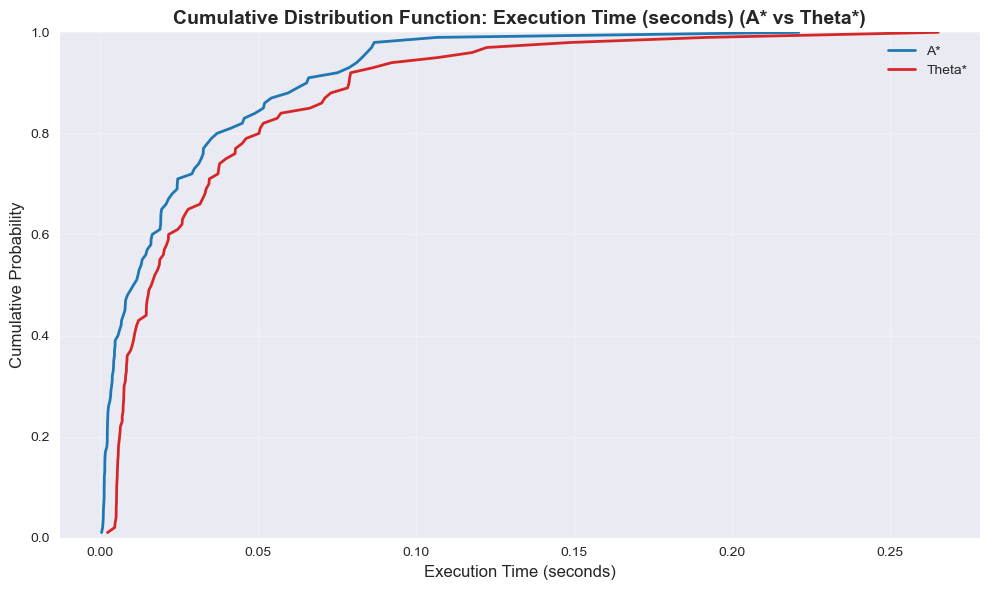

Saved: algorithm_analysis_plots_20250917_144437/03_cdf_execution_time_bfs_dijkstra.png


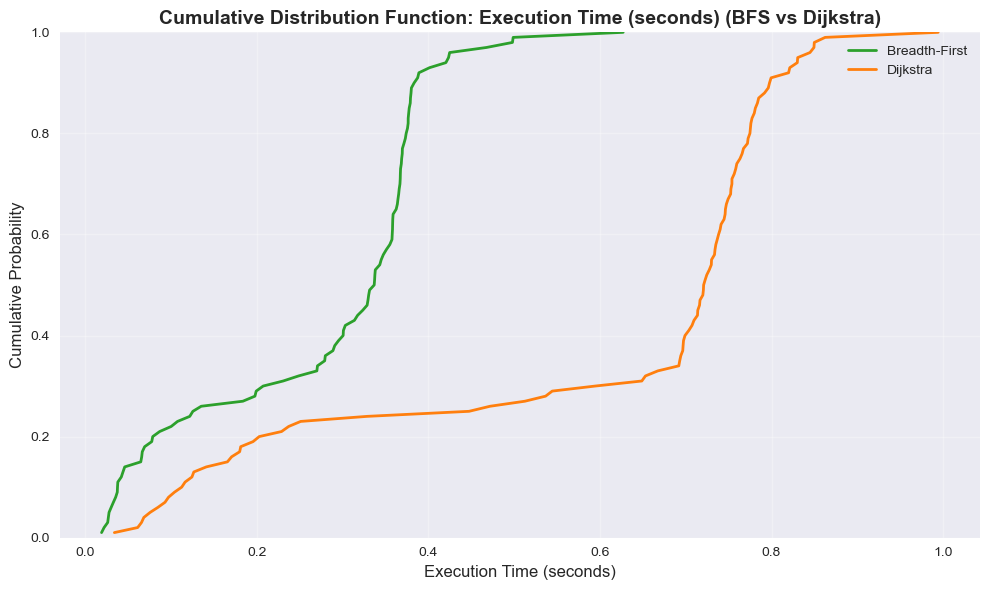

Saved: algorithm_analysis_plots_20250917_144437/03_cdf_operations_astar_theta.png


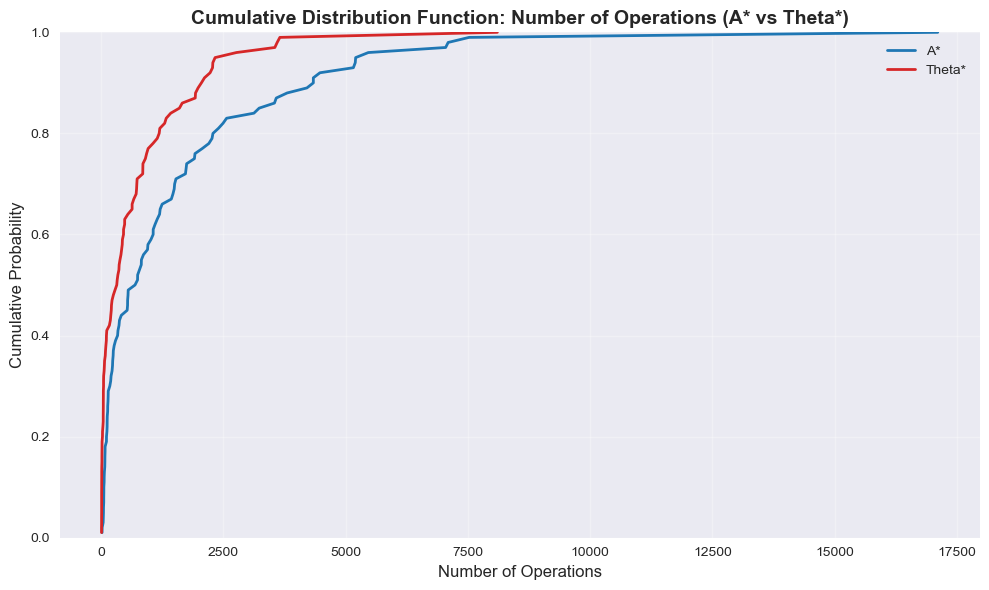

Saved: algorithm_analysis_plots_20250917_144437/03_cdf_operations_bfs_dijkstra.png


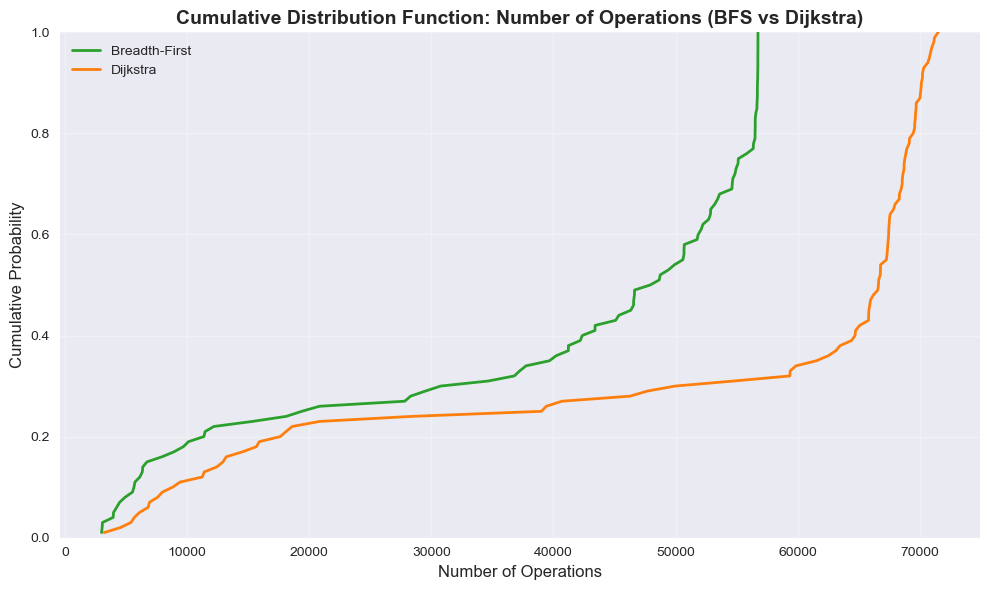

Saved: algorithm_analysis_plots_20250917_144437/03_cdf_path_length.png


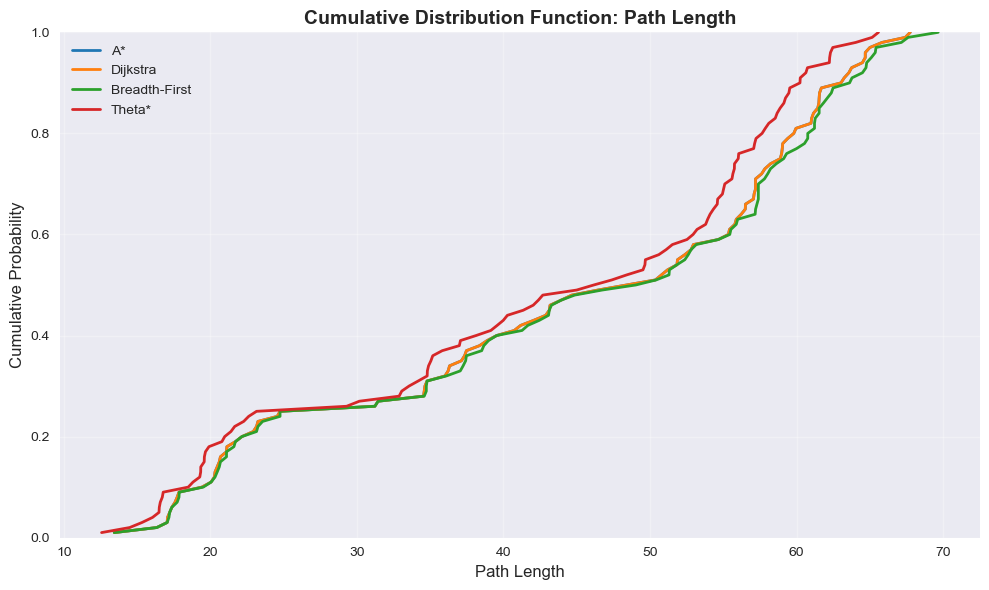

Saved: algorithm_analysis_plots_20250917_144437/03_cdf_path_efficiency.png


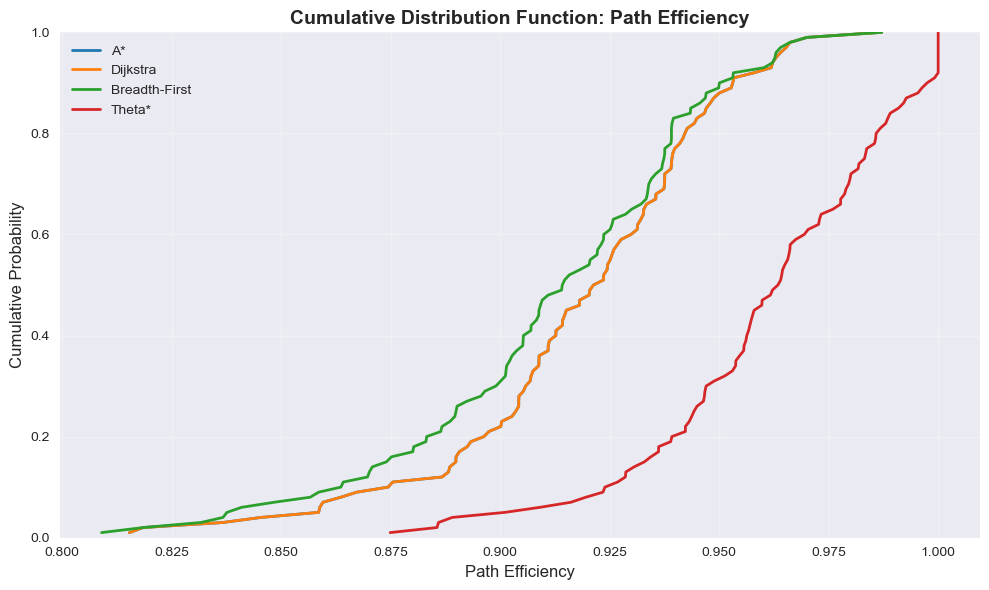

In [5]:
# Create individual Cumulative Distribution Functions (CDFs) for each metric
# For execution_time and operations, create separate plots for A*/Theta* and BFS/Dijkstra
time_ops_metrics = ['execution_time', 'operations']
time_ops_titles = ['Execution Time (seconds)', 'Number of Operations']

# Create CDFs for execution_time and operations with algorithm groups
for metric, title in zip(time_ops_metrics, time_ops_titles):
    # Plot 1: A* and Theta*
    plt.figure(figsize=(10, 6))
    
    for algorithm in ['A*', 'Theta*']:
        data = df[df['algorithm'] == algorithm][metric].sort_values()
        y = np.arange(1, len(data) + 1) / len(data)
        plt.plot(data, y, label=algorithm, linewidth=2, color=ALGORITHM_COLORS[algorithm])
    
    plt.title(f'Cumulative Distribution Function: {title} (A* vs Theta*)', fontsize=14, fontweight='bold')
    plt.xlabel(title, fontsize=12)
    plt.ylabel('Cumulative Probability', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.tight_layout()
    
    # Save the plot
    filename = f"03_cdf_{metric}_astar_theta.png"
    save_plot(filename)
    plt.show()
    
    # Plot 2: BFS and Dijkstra
    plt.figure(figsize=(10, 6))
    
    for algorithm in ['Breadth-First', 'Dijkstra']:
        data = df[df['algorithm'] == algorithm][metric].sort_values()
        y = np.arange(1, len(data) + 1) / len(data)
        plt.plot(data, y, label=algorithm, linewidth=2, color=ALGORITHM_COLORS[algorithm])
    
    plt.title(f'Cumulative Distribution Function: {title} (BFS vs Dijkstra)', fontsize=14, fontweight='bold')
    plt.xlabel(title, fontsize=12)
    plt.ylabel('Cumulative Probability', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.tight_layout()
    
    # Save the plot
    filename = f"03_cdf_{metric}_bfs_dijkstra.png"
    save_plot(filename)
    plt.show()

# Create CDFs for path_length and path_efficiency (all algorithms together)
other_metrics = ['path_length', 'path_efficiency']
other_titles = ['Path Length', 'Path Efficiency']

for metric, title in zip(other_metrics, other_titles):
    plt.figure(figsize=(10, 6))
    
    for algorithm in df['algorithm'].unique():
        data = df[df['algorithm'] == algorithm][metric].sort_values()
        y = np.arange(1, len(data) + 1) / len(data)
        plt.plot(data, y, label=algorithm, linewidth=2, color=ALGORITHM_COLORS[algorithm])
    
    plt.title(f'Cumulative Distribution Function: {title}', fontsize=14, fontweight='bold')
    plt.xlabel(title, fontsize=12)
    plt.ylabel('Cumulative Probability', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.tight_layout()
    
    # Save the plot
    filename = f"03_cdf_{metric}.png"
    save_plot(filename)
    plt.show()


Saved: algorithm_analysis_plots_20250917_144437/03_violin_execution_time.png


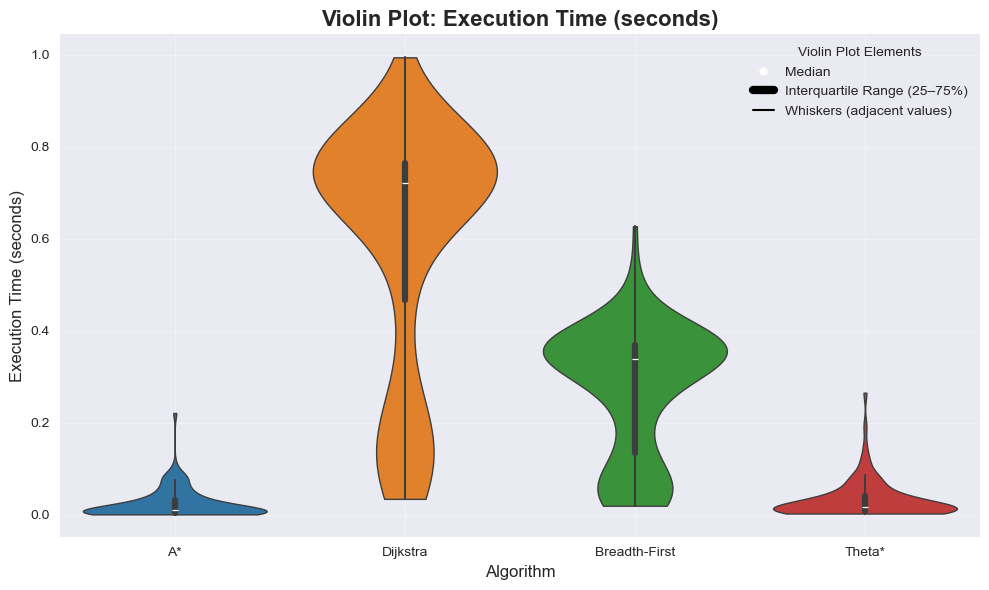

Saved: algorithm_analysis_plots_20250917_144437/03_violin_operations.png


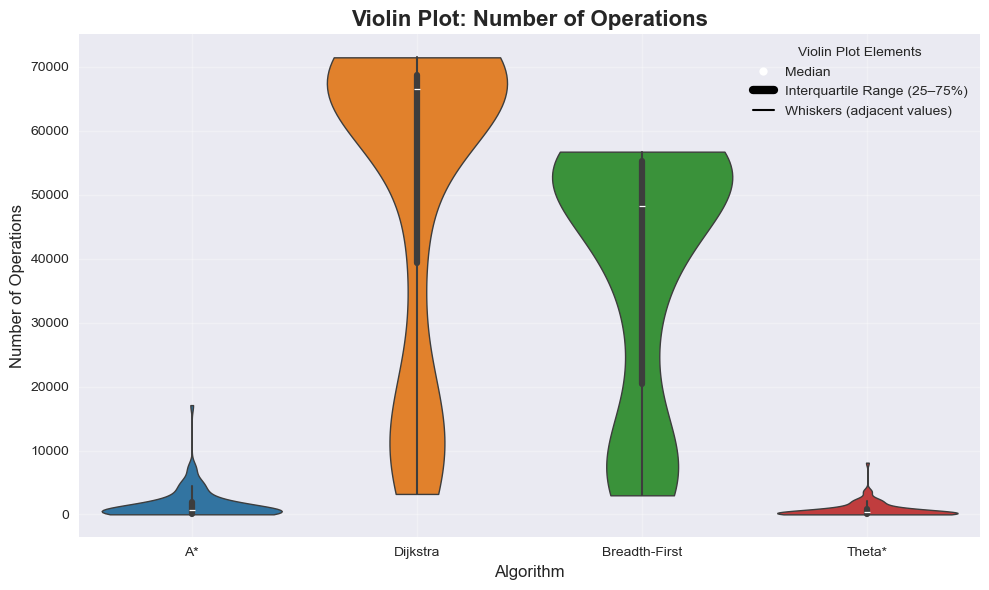

Saved: algorithm_analysis_plots_20250917_144437/03_violin_path_length.png


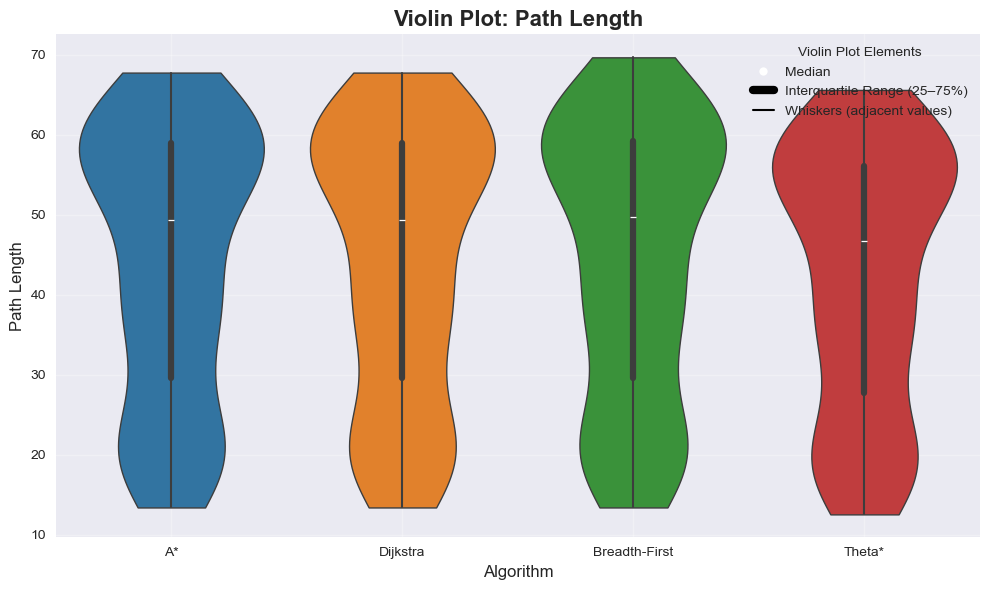

Saved: algorithm_analysis_plots_20250917_144437/03_violin_path_efficiency.png


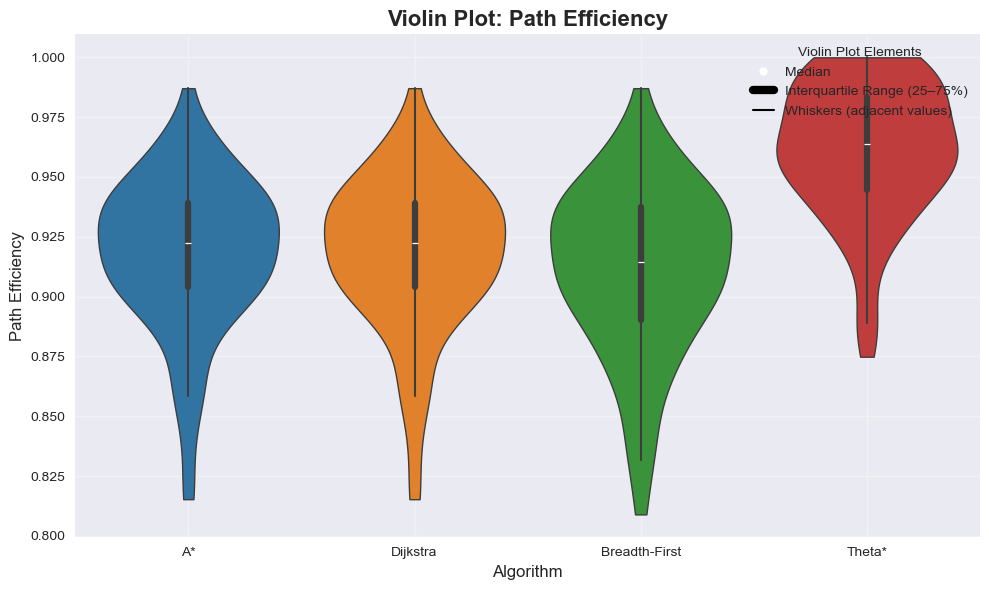

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Define metrics and titles for plotting
metrics = ['execution_time', 'operations', 'path_length', 'path_efficiency']
titles = ['Execution Time (seconds)', 'Number of Operations', 'Path Length', 'Path Efficiency']

for metric, title in zip(metrics, titles):
    plt.figure(figsize=(10, 6))

    sns.violinplot(
        data=df,
        x="algorithm",
        y=metric,
        inner="box",       # show median & quartiles inside
        cut=0,
        scale="width",
        linewidth=1,
        palette=ALGORITHM_COLORS
    )

    plt.title(f'Violin Plot: {title}', fontsize=16, fontweight='bold')
    plt.xlabel("Algorithm", fontsize=12)
    plt.ylabel(title, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # --- Custom legend for inner="box" ---
    median = Line2D([], [], linestyle='None', marker='o',
                    markersize=6, markerfacecolor='white', markeredgecolor='black',
                    label='Median')

    iqr = Line2D([], [], color="black", linewidth=6,
                 label='Interquartile Range (25–75%)')

    whiskers = Line2D([], [], color="black", linewidth=1.5,
                      label='Whiskers (adjacent values)')

    plt.legend(
        handles=[median, iqr, whiskers],
        title="Violin Plot Elements",
        loc="upper right",
        fontsize=10,
        handlelength=1.5
    )

    filename = f"03_violin_{metric}.png"
    save_plot(filename)
    plt.show()

## Analysis by Distance Categories


Saved: algorithm_analysis_plots_20250917_144437/04_distance_category_execution_time.png


<Figure size 1200x800 with 0 Axes>

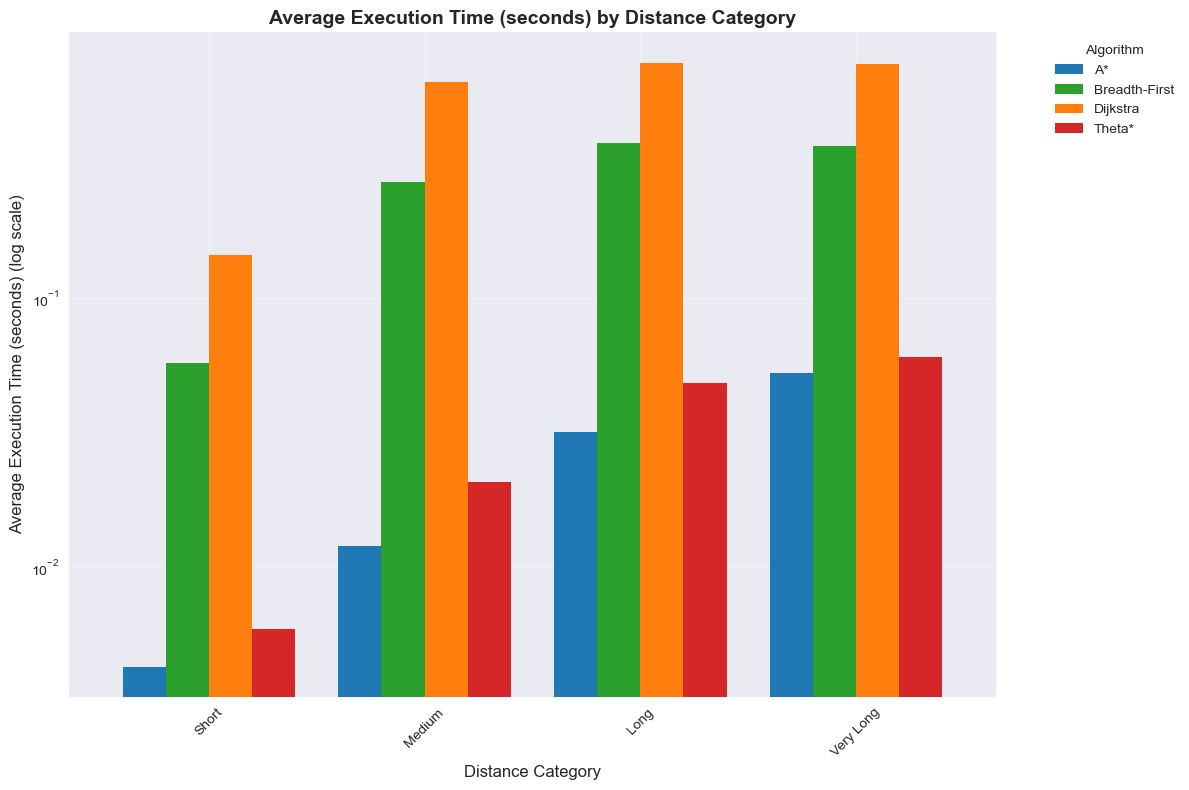

Saved: algorithm_analysis_plots_20250917_144437/04_distance_category_operations.png


<Figure size 1200x800 with 0 Axes>

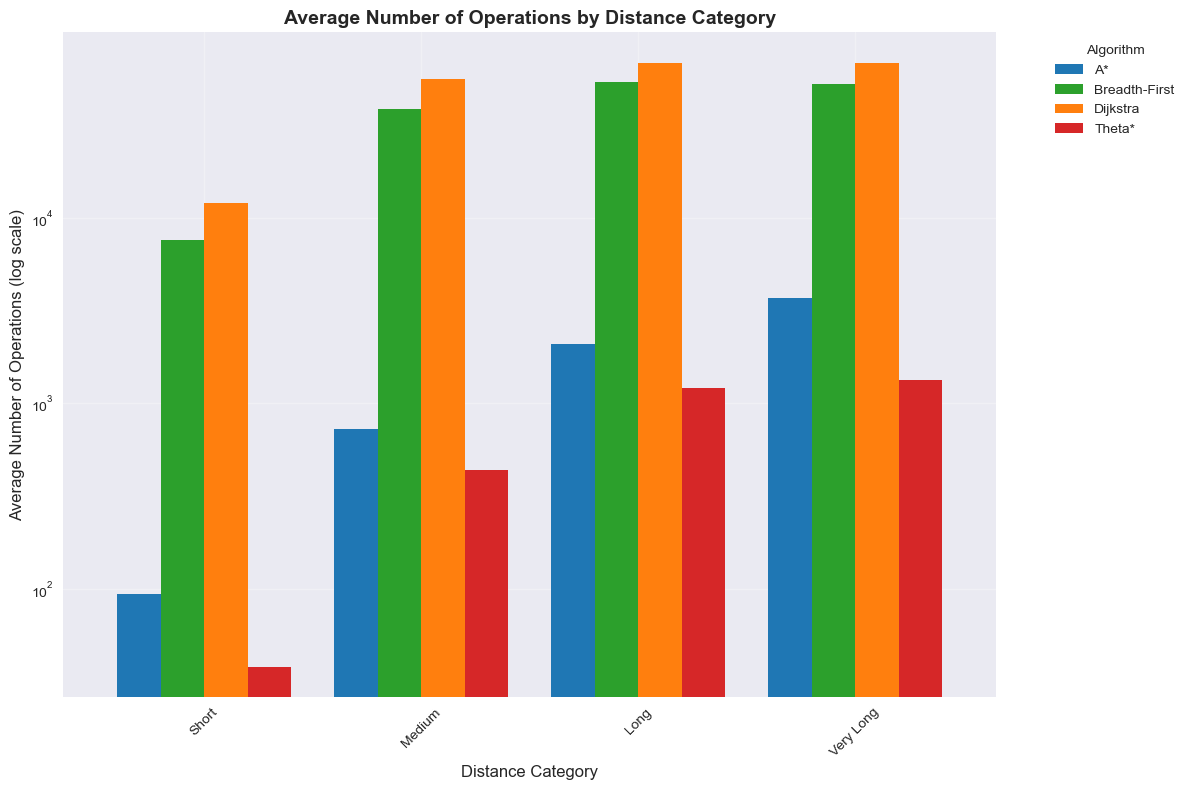

Saved: algorithm_analysis_plots_20250917_144437/04_distance_category_path_length.png


<Figure size 1200x800 with 0 Axes>

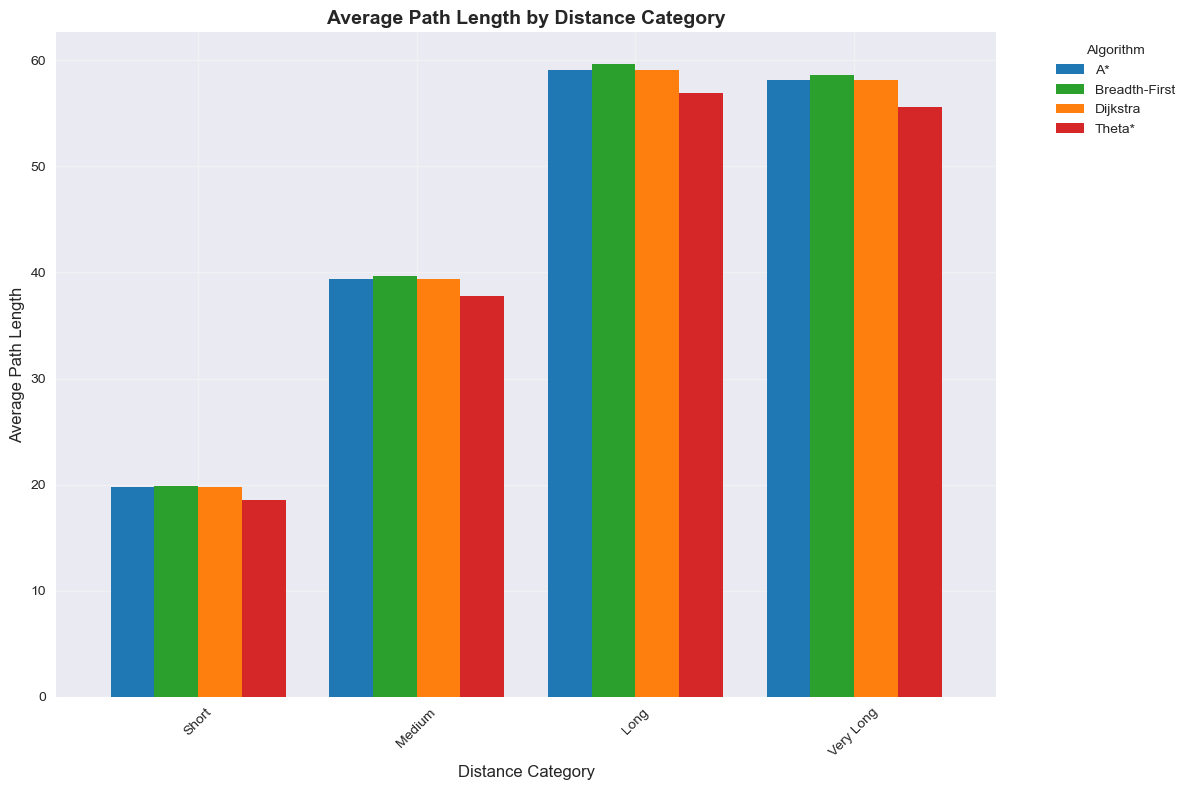

Saved: algorithm_analysis_plots_20250917_144437/04_distance_category_path_efficiency.png


<Figure size 1200x800 with 0 Axes>

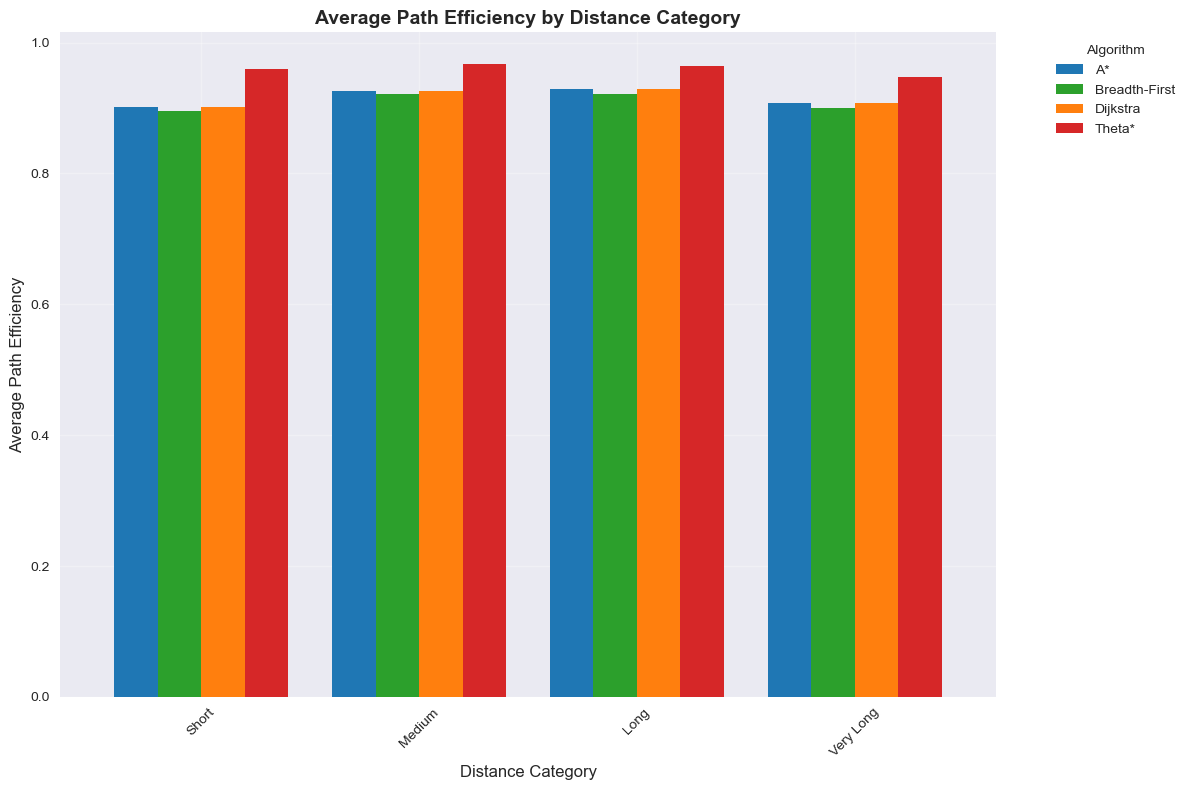

In [7]:
for metric, title in zip(metrics, titles):
    plt.figure(figsize=(12, 8))
    
    # Create grouped bar plot with ordered categories
    order = ['Short', 'Medium', 'Long', 'Very Long']
    ordered = (
        df.assign(distance_category=pd.Categorical(df['distance_category'], categories=order, ordered=True))
          .groupby(['distance_category', 'algorithm'])[metric].mean().unstack()
          .reindex(order)
    )
    
    # Match algorithm order to ALGORITHM_COLORS keys
    colors = [ALGORITHM_COLORS[algo] for algo in ordered.columns]
    
    ax = ordered.plot(kind='bar', width=0.8, color=colors)
    
    plt.title(f'Average {title} by Distance Category', fontsize=14, fontweight='bold')
    plt.xlabel('Distance Category', fontsize=12)
    
    # Use log scale for time and operations
    if metric in ['execution_time', 'operations']:
        ax.set_yscale('log')
        plt.ylabel(f'Average {title} (log scale)', fontsize=12)
    else:
        plt.ylabel(f'Average {title}', fontsize=12)
    
    plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot
    filename = f"04_distance_category_{metric}.png"
    save_plot(filename)
    plt.show()

In [8]:
# Detailed analysis by distance category
print("=== DETAILED ANALYSIS BY DISTANCE CATEGORY ===\n")

for category in ['Short', 'Medium', 'Long', 'Very Long']:
    print(f"\n{'='*60}")
    print(f"DISTANCE CATEGORY: {category.upper()}")
    print(f"{'='*60}")
    
    category_data = df[df['distance_category'] == category]
    print(f"Number of test cases: {len(category_data) // 4}")
    print(f"Distance range: {category_data['euclidean_distance'].min():.2f} - {category_data['euclidean_distance'].max():.2f}")
    
    for metric in metrics:
        print(f"\n--- {metric.upper()} ---")
        stats_by_algorithm = category_data.groupby('algorithm')[metric].agg([
            'mean', 'median', 'std', 'min', 'max'
        ]).round(4)
        print(stats_by_algorithm)
        
        # Find best performing algorithm for this metric
        if metric == 'path_efficiency':
            best_algorithm = stats_by_algorithm['mean'].idxmax()
            best_value = stats_by_algorithm['mean'].max()
            print(f"Best algorithm: {best_algorithm} (mean: {best_value:.4f})")
        else:
            best_algorithm = stats_by_algorithm['mean'].idxmin()
            best_value = stats_by_algorithm['mean'].min()
            print(f"Best algorithm: {best_algorithm} (mean: {best_value:.4f})")


=== DETAILED ANALYSIS BY DISTANCE CATEGORY ===


DISTANCE CATEGORY: SHORT
Number of test cases: 20
Distance range: 11.00 - 21.66

--- EXECUTION_TIME ---
                 mean  median     std     min     max
algorithm                                            
A*             0.0042  0.0014  0.0079  0.0005  0.0298
Breadth-First  0.0574  0.0433  0.0414  0.0194  0.1995
Dijkstra       0.1452  0.1258  0.0919  0.0343  0.4476
Theta*         0.0058  0.0055  0.0016  0.0024  0.0109
Best algorithm: A* (mean: 0.0042)

--- OPERATIONS ---
                   mean   median        std   min    max
algorithm                                               
A*                93.90     69.0    82.6450    24    417
Breadth-First   7620.00   6232.0  5662.3922  2997  28298
Dijkstra       11949.05  11322.5  7950.6654  3211  39413
Theta*            38.25     16.5    46.7365    13    216
Best algorithm: Theta* (mean: 38.2500)

--- PATH_LENGTH ---
                  mean   median     std      min      max
algorithm

## Statistical Tests and Comparisons


In [9]:
# Normality tests for each metric and algorithm
print("=== NORMALITY TESTS ===\n")

for metric in metrics:
    print(f"\n{metric.upper()}:")
    print("-" * 40)
    
    for algorithm in df['algorithm'].unique():
        data = df[df['algorithm'] == algorithm][metric]
        
        # Shapiro-Wilk test (good for small samples)
        if len(data) >= 3 and len(data) <= 5000:
            shapiro_stat, shapiro_p = shapiro(data)
            print(f"{algorithm:12} - Shapiro-Wilk: p={shapiro_p:.4f} {'(normal)' if shapiro_p > 0.05 else '(not normal)'}")
        
        # D'Agostino's normality test
        if len(data) >= 8:
            dagostino_stat, dagostino_p = normaltest(data)
            print(f"{algorithm:12} - D'Agostino: p={dagostino_p:.4f} {'(normal)' if dagostino_p > 0.05 else '(not normal)'}")


=== NORMALITY TESTS ===


EXECUTION_TIME:
----------------------------------------
A*           - Shapiro-Wilk: p=0.0000 (not normal)
A*           - D'Agostino: p=0.0000 (not normal)
Dijkstra     - Shapiro-Wilk: p=0.0000 (not normal)
Dijkstra     - D'Agostino: p=0.0002 (not normal)
Breadth-First - Shapiro-Wilk: p=0.0000 (not normal)
Breadth-First - D'Agostino: p=0.0108 (not normal)
Theta*       - Shapiro-Wilk: p=0.0000 (not normal)
Theta*       - D'Agostino: p=0.0000 (not normal)

OPERATIONS:
----------------------------------------
A*           - Shapiro-Wilk: p=0.0000 (not normal)
A*           - D'Agostino: p=0.0000 (not normal)
Dijkstra     - Shapiro-Wilk: p=0.0000 (not normal)
Dijkstra     - D'Agostino: p=0.0001 (not normal)
Breadth-First - Shapiro-Wilk: p=0.0000 (not normal)
Breadth-First - D'Agostino: p=0.0000 (not normal)
Theta*       - Shapiro-Wilk: p=0.0000 (not normal)
Theta*       - D'Agostino: p=0.0000 (not normal)

PATH_LENGTH:
----------------------------------------
A*  

=== INDIVIDUAL ALGORITHM CORRELATION ANALYSIS ===


--- A* Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.498       0.493        0.997
execution_time             0.498           1.000       0.962        0.547
operations                 0.493           0.962       1.000        0.541
path_length                0.997           0.547       0.541        1.000
Saved: algorithm_analysis_plots_20250917_144437/05_correlation_matrix_astar.png


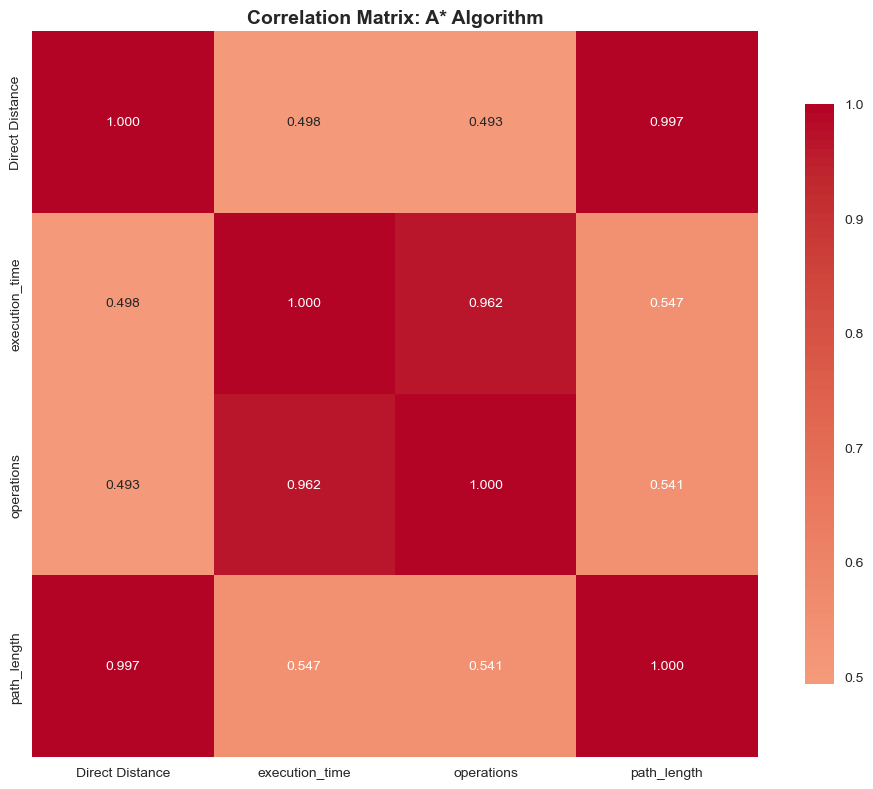


--- Dijkstra Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.858       0.887        0.997
execution_time             0.858           1.000       0.986        0.853
operations                 0.887           0.986       1.000        0.883
path_length                0.997           0.853       0.883        1.000
Saved: algorithm_analysis_plots_20250917_144437/05_correlation_matrix_dijkstra.png


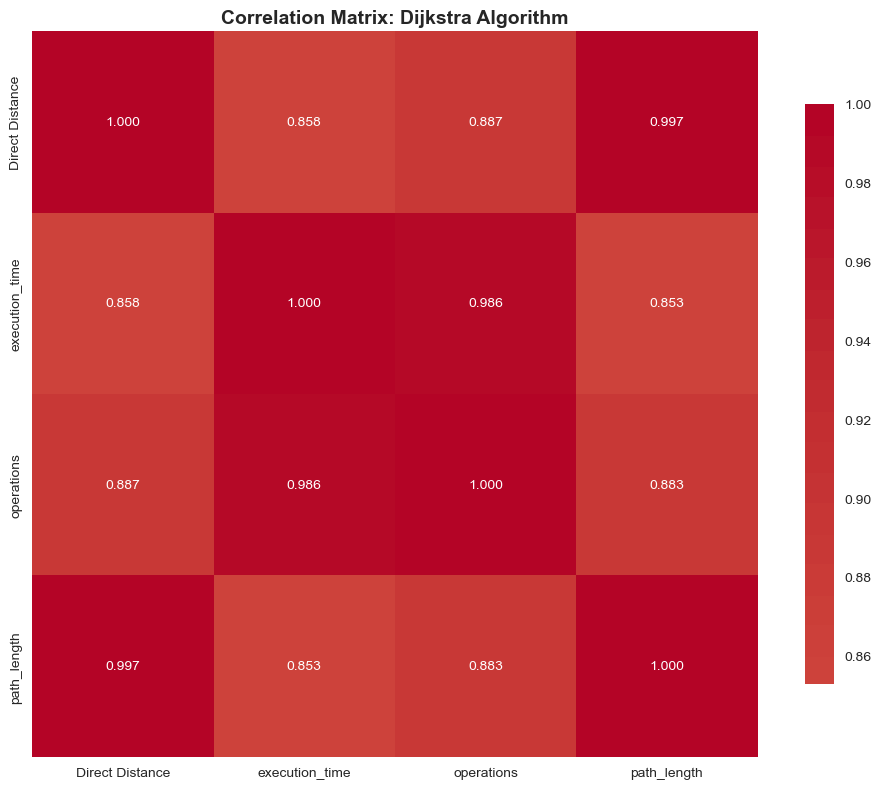


--- Breadth-First Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.887       0.921        0.995
execution_time             0.887           1.000       0.963        0.891
operations                 0.921           0.963       1.000        0.927
path_length                0.995           0.891       0.927        1.000
Saved: algorithm_analysis_plots_20250917_144437/05_correlation_matrix_breadth_first.png


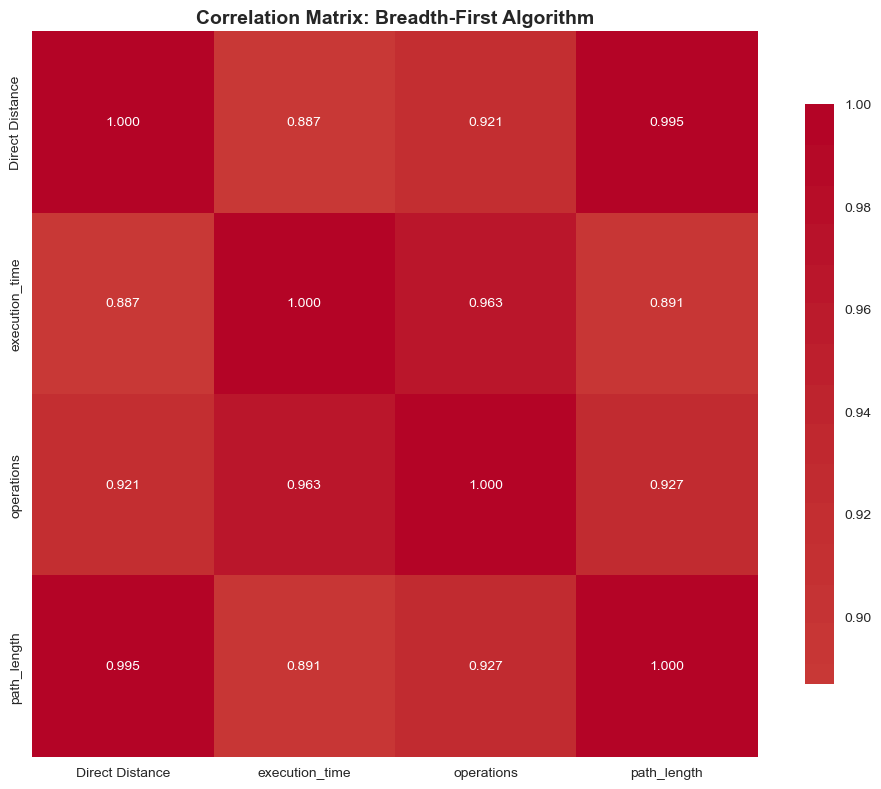


--- Theta* Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.531       0.503        0.998
execution_time             0.531           1.000       0.945        0.556
operations                 0.503           0.945       1.000        0.532
path_length                0.998           0.556       0.532        1.000
Saved: algorithm_analysis_plots_20250917_144437/05_correlation_matrix_thetastar.png


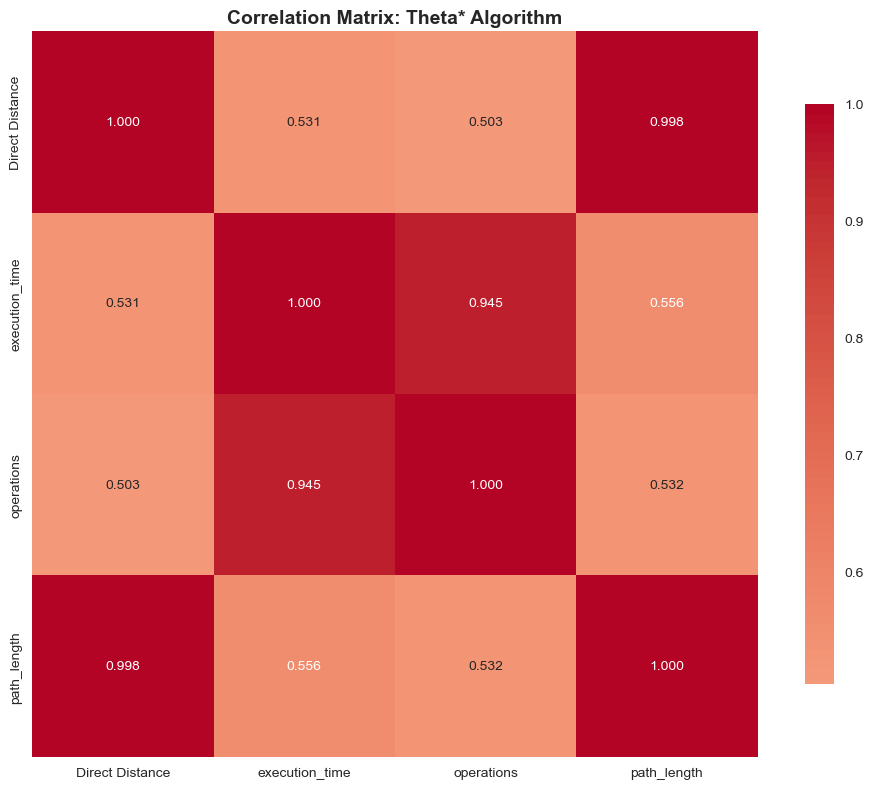

In [10]:
# Individual correlation heatmaps for each algorithm
print("=== INDIVIDUAL ALGORITHM CORRELATION ANALYSIS ===\n")

# Calculate correlation matrix for numerical variables
numerical_vars = ['euclidean_distance', 'execution_time', 'operations', 'path_length']

# Create individual correlation heatmaps for each algorithm
for algorithm in df['algorithm'].unique():
    print(f"\n--- {algorithm} Algorithm ---")
    
    # Get data for this algorithm
    algo_data = df[df['algorithm'] == algorithm][numerical_vars]
    correlation_matrix = algo_data.corr()

    # Rename axis labels for display
    renamed_matrix = correlation_matrix.rename(
        index={'euclidean_distance': 'Direct Distance'},
        columns={'euclidean_distance': 'Direct Distance'}
    )
    
    print("Correlation Matrix:")
    print(renamed_matrix.round(3))
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(renamed_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
    plt.title(f'Correlation Matrix: {algorithm} Algorithm', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save the plot
    filename = f"05_correlation_matrix_{algorithm.replace('*', 'star').replace('-', '_').lower()}.png"
    save_plot(filename)
    plt.show()

=== INDIVIDUAL ALGORITHM CORRELATION ANALYSIS ===


--- A* Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.498       0.493        0.997
execution_time             0.498           1.000       0.962        0.547
operations                 0.493           0.962       1.000        0.541
path_length                0.997           0.547       0.541        1.000
Saved: algorithm_analysis_plots_20250917_144437/05_correlation_matrix_astar.png


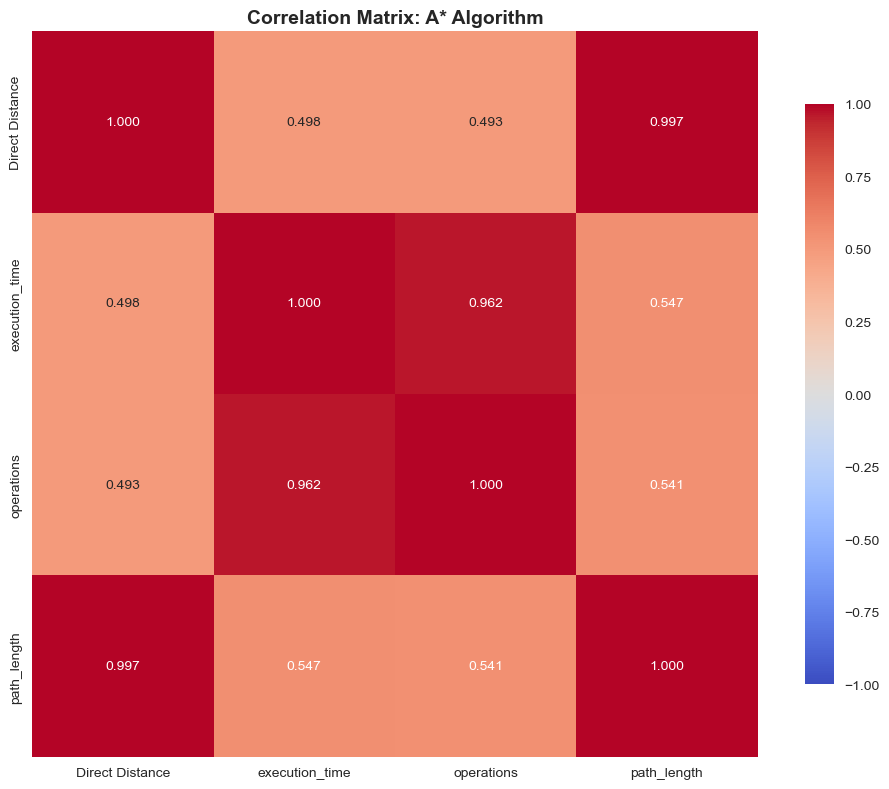


--- Dijkstra Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.858       0.887        0.997
execution_time             0.858           1.000       0.986        0.853
operations                 0.887           0.986       1.000        0.883
path_length                0.997           0.853       0.883        1.000
Saved: algorithm_analysis_plots_20250917_144437/05_correlation_matrix_dijkstra.png


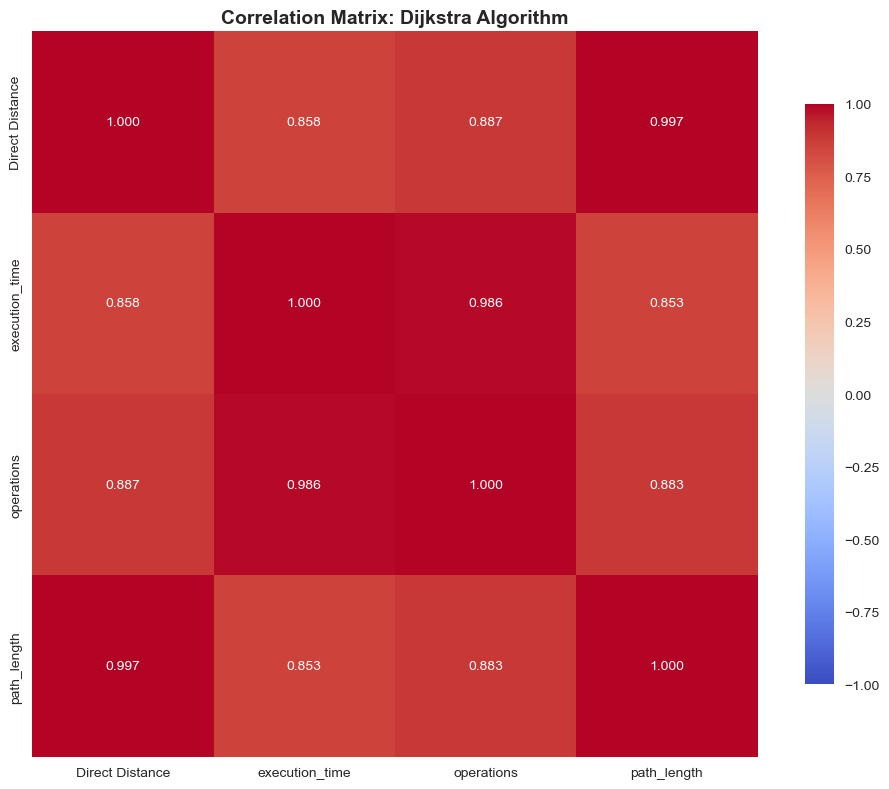


--- Breadth-First Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.887       0.921        0.995
execution_time             0.887           1.000       0.963        0.891
operations                 0.921           0.963       1.000        0.927
path_length                0.995           0.891       0.927        1.000
Saved: algorithm_analysis_plots_20250917_144437/05_correlation_matrix_breadth_first.png


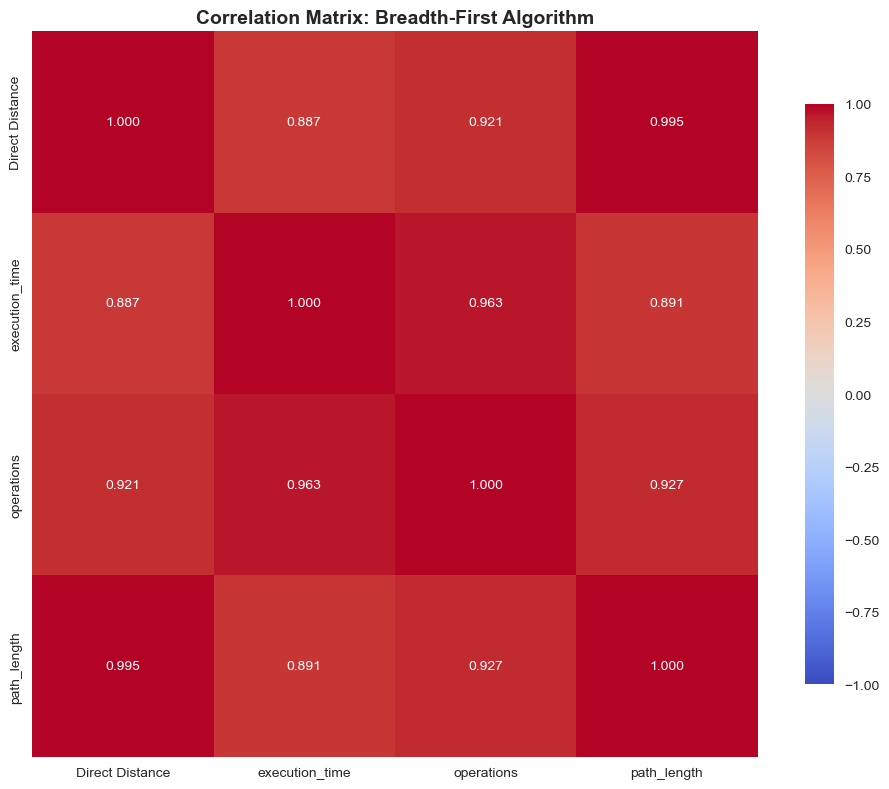


--- Theta* Algorithm ---
Correlation Matrix:
                 Direct Distance  execution_time  operations  path_length
Direct Distance            1.000           0.531       0.503        0.998
execution_time             0.531           1.000       0.945        0.556
operations                 0.503           0.945       1.000        0.532
path_length                0.998           0.556       0.532        1.000
Saved: algorithm_analysis_plots_20250917_144437/05_correlation_matrix_thetastar.png


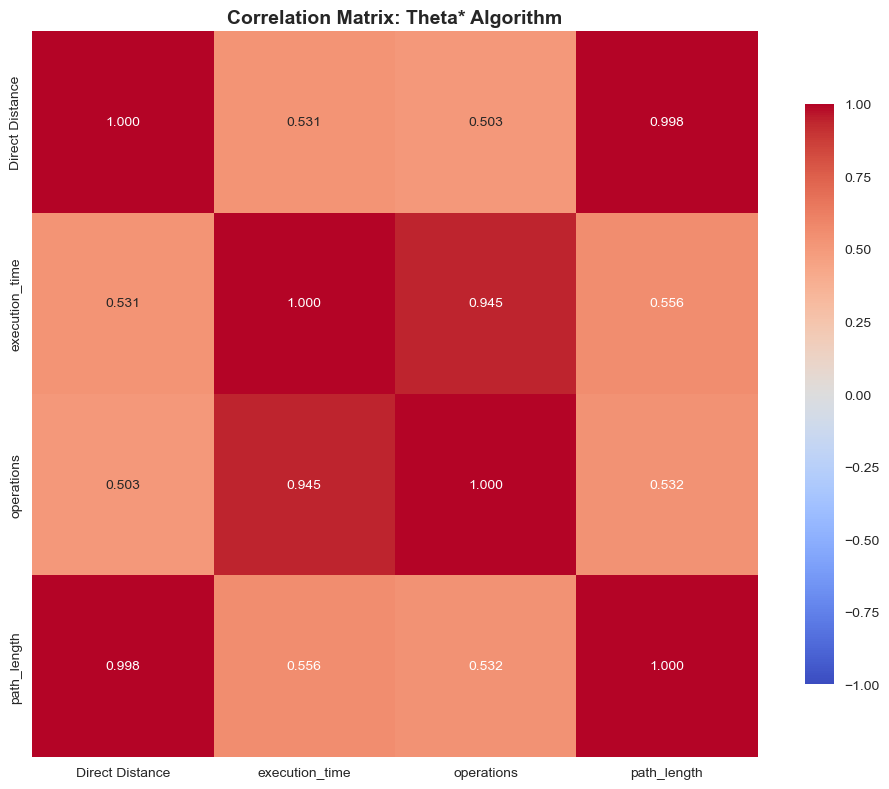

In [11]:
# Individual correlation heatmaps for each algorithm
print("=== INDIVIDUAL ALGORITHM CORRELATION ANALYSIS ===\n")

# Calculate correlation matrix for numerical variables
numerical_vars = ['euclidean_distance', 'execution_time', 'operations', 'path_length']

# Create individual correlation heatmaps for each algorithm
for algorithm in df['algorithm'].unique():
    print(f"\n--- {algorithm} Algorithm ---")
    
    # Get data for this algorithm
    algo_data = df[df['algorithm'] == algorithm][numerical_vars]
    correlation_matrix = algo_data.corr()

    # Rename axis labels for display
    renamed_matrix = correlation_matrix.rename(
        index={'euclidean_distance': 'Direct Distance'},
        columns={'euclidean_distance': 'Direct Distance'}
    )
    
    print("Correlation Matrix:")
    print(renamed_matrix.round(3))
    
    # Create heatmap with fixed color range
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        renamed_matrix,
        annot=True,
        cmap='coolwarm',
        center=0,
        vmin=-1, vmax=1,      # <-- full correlation range
        square=True,
        fmt='.3f',
        cbar_kws={'shrink': 0.8}
    )
    
    plt.title(f'Correlation Matrix: {algorithm} Algorithm', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save the plot
    filename = f"05_correlation_matrix_{algorithm.replace('*', 'star').replace('-', '_').lower()}.png"
    save_plot(filename)
    plt.show()

## Performance Summary and Rankings


In [12]:
# Create performance summary table
print("=== ALGORITHM PERFORMANCE SUMMARY ===\n")

# Calculate overall performance scores (lower is better for most metrics)
performance_scores = {}

for algorithm in df['algorithm'].unique():
    algo_data = df[df['algorithm'] == algorithm]
    
    # Normalize scores (0-1 scale, lower is better for execution_time, operations, path_length)
    # Higher is better for path_efficiency
    
    # Execution time score (lower is better)
    exec_time_score = 1 - (algo_data['execution_time'].mean() - df['execution_time'].min()) / (df['execution_time'].max() - df['execution_time'].min())
    
    # Operations score (lower is better)
    ops_score = 1 - (algo_data['operations'].mean() - df['operations'].min()) / (df['operations'].max() - df['operations'].min())
    
    # Path length score (lower is better)
    path_len_score = 1 - (algo_data['path_length'].mean() - df['path_length'].min()) / (df['path_length'].max() - df['path_length'].min())
    
    # Path efficiency score (higher is better)
    efficiency_score = (algo_data['path_efficiency'].mean() - df['path_efficiency'].min()) / (df['path_efficiency'].max() - df['path_efficiency'].min())
    
    # Overall score (average of normalized scores)
    overall_score = (exec_time_score + ops_score + path_len_score + efficiency_score) / 4
    
    performance_scores[algorithm] = {
        'execution_time_score': exec_time_score,
        'operations_score': ops_score,
        'path_length_score': path_len_score,
        'efficiency_score': efficiency_score,
        'overall_score': overall_score
    }

# Create summary DataFrame
summary_df = pd.DataFrame(performance_scores).T
summary_df = summary_df.sort_values('overall_score', ascending=False)

print("Performance Scores (0-1 scale, higher is better):")
print(summary_df.round(3))

print("\nAlgorithm Rankings (by overall score):")
for i, (algorithm, row) in enumerate(summary_df.iterrows(), 1):
    print(f"{i}. {algorithm}: {row['overall_score']:.3f}")


=== ALGORITHM PERFORMANCE SUMMARY ===

Performance Scores (0-1 scale, higher is better):
               execution_time_score  operations_score  path_length_score  \
Theta*                        0.968             0.990              0.479   
A*                            0.977             0.979              0.447   
Breadth-First                 0.724             0.453              0.441   
Dijkstra                      0.404             0.264              0.447   

               efficiency_score  overall_score  
Theta*                    0.796          0.808  
A*                        0.571          0.743  
Breadth-First             0.537          0.539  
Dijkstra                  0.571          0.421  

Algorithm Rankings (by overall score):
1. Theta*: 0.808
2. A*: 0.743
3. Breadth-First: 0.539
4. Dijkstra: 0.421


Saved: algorithm_analysis_plots_20250917_144437/06_performance_summary.png


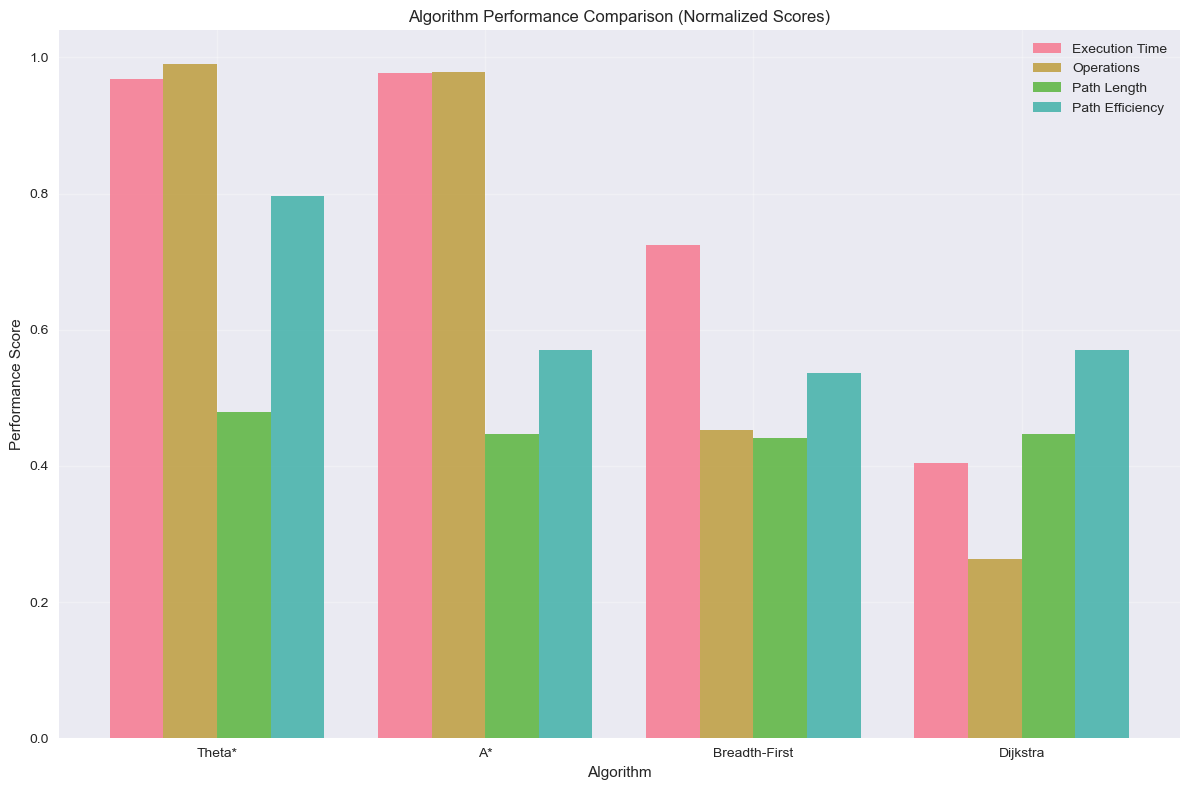

In [13]:
# Visualize performance scores
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(summary_df))
width = 0.2

ax.bar(x - 1.5*width, summary_df['execution_time_score'], width, label='Execution Time', alpha=0.8)
ax.bar(x - 0.5*width, summary_df['operations_score'], width, label='Operations', alpha=0.8)
ax.bar(x + 0.5*width, summary_df['path_length_score'], width, label='Path Length', alpha=0.8)
ax.bar(x + 1.5*width, summary_df['efficiency_score'], width, label='Path Efficiency', alpha=0.8)

ax.set_xlabel('Algorithm')
ax.set_ylabel('Performance Score')
ax.set_title('Algorithm Performance Comparison (Normalized Scores)')
ax.set_xticks(x)
ax.set_xticklabels(summary_df.index)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save the plot
filename = "06_performance_summary.png"
save_plot(filename)
plt.show()


## Distance-Specific Performance Analysis


Saved: algorithm_analysis_plots_20250917_144437/07_distance_specific_short.png


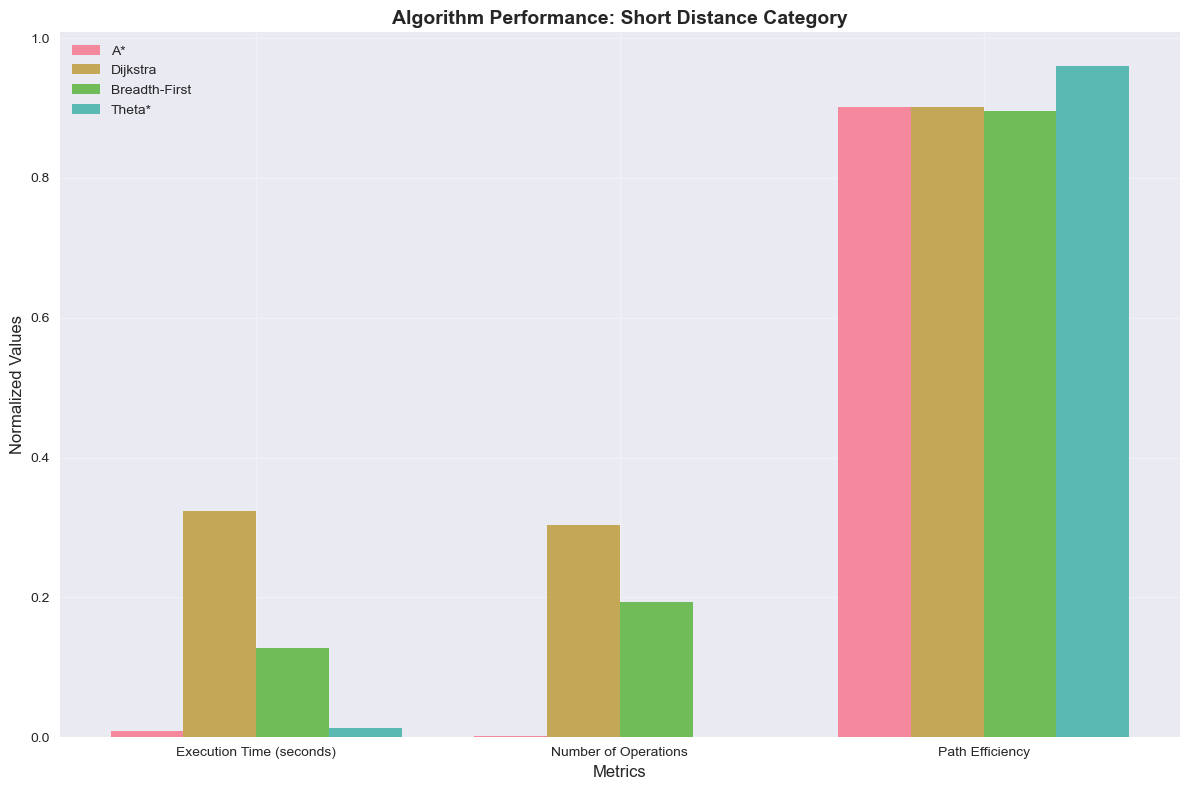

Saved: algorithm_analysis_plots_20250917_144437/07_distance_specific_medium.png


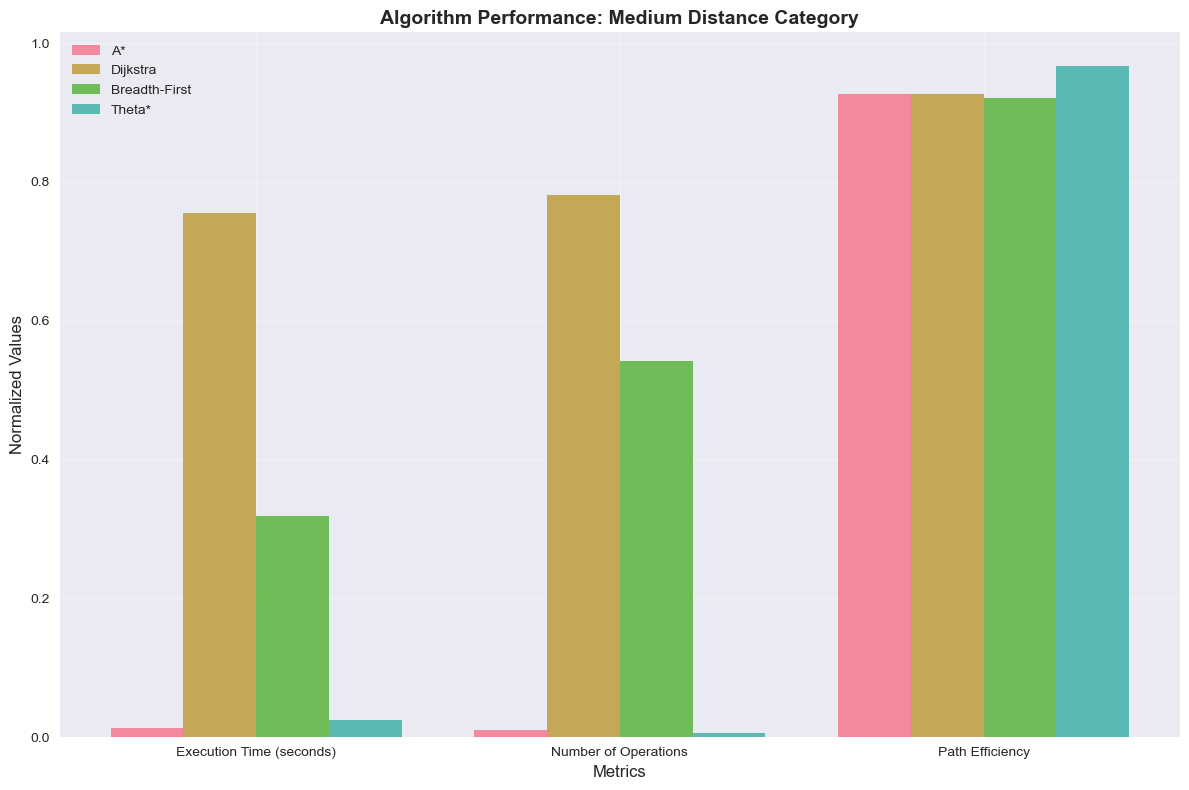

Saved: algorithm_analysis_plots_20250917_144437/07_distance_specific_long.png


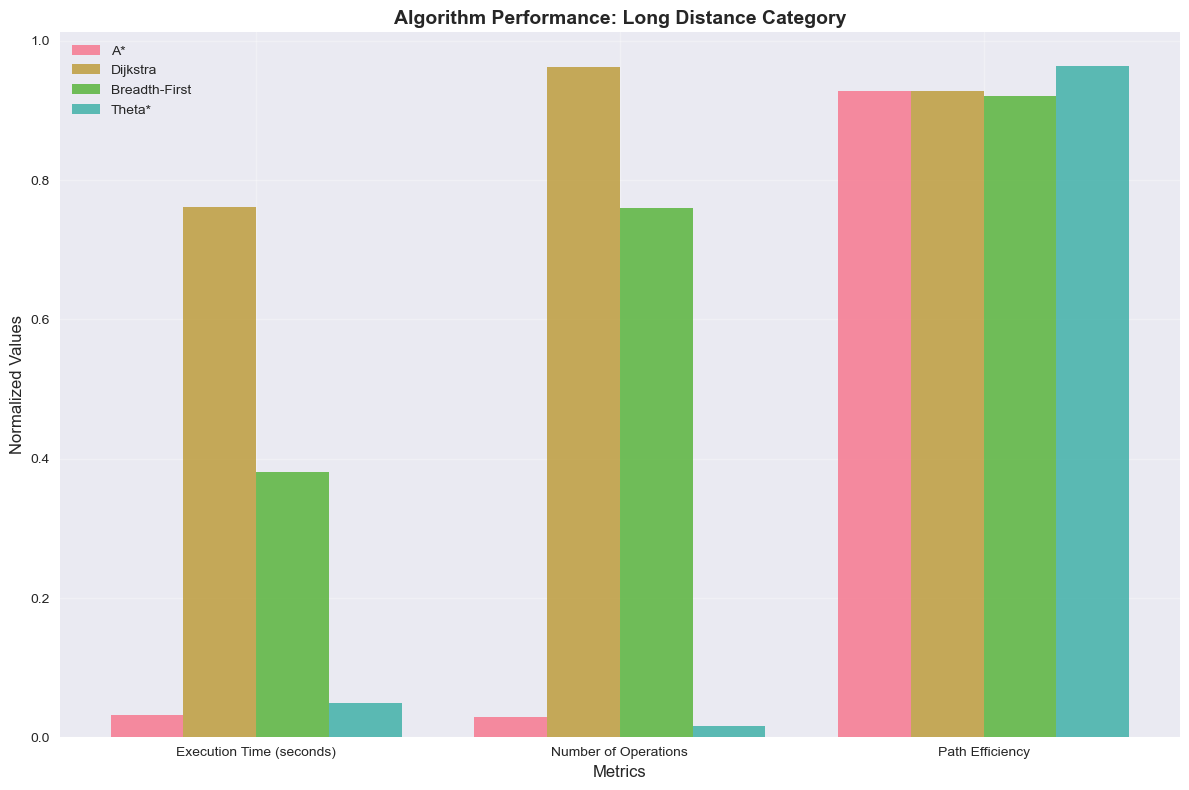

Saved: algorithm_analysis_plots_20250917_144437/07_distance_specific_very_long.png


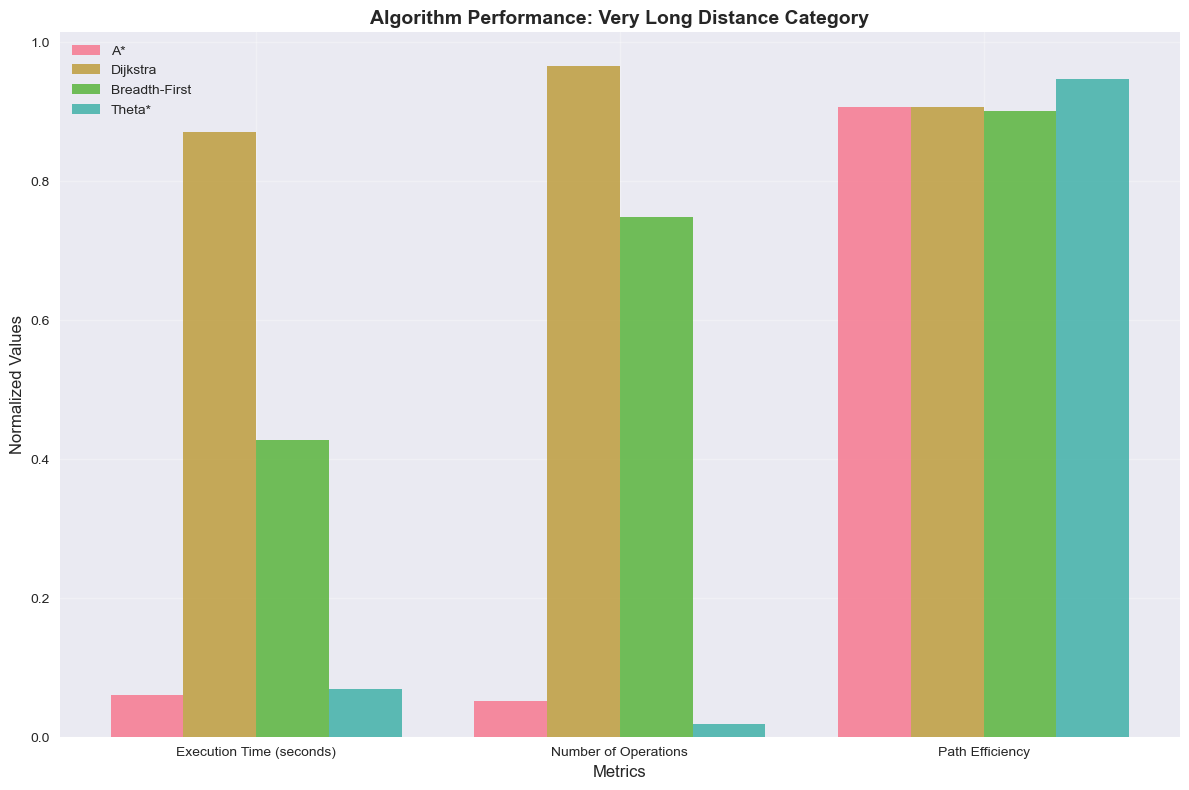

In [14]:
# Create individual distance-specific performance analysis plots
distance_categories = ['Short', 'Medium', 'Long', 'Very Long']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

for category, color in zip(distance_categories, colors):
    plt.figure(figsize=(12, 8))
    
    category_data = df[df['distance_category'] == category]
    
    # Create grouped bar chart for this distance category
    metrics_to_plot = ['execution_time', 'operations', 'path_efficiency']
    metric_titles = ['Execution Time (seconds)', 'Number of Operations', 'Path Efficiency']
    
    x = np.arange(len(metrics_to_plot))
    width = 0.2
    
    for j, algorithm in enumerate(df['algorithm'].unique()):
        algo_data = category_data[category_data['algorithm'] == algorithm]
        values = [algo_data[metric].mean() for metric in metrics_to_plot]
        
        # Normalize values for better comparison (except for path_efficiency)
        normalized_values = []
        for i, (metric, value) in enumerate(zip(metrics_to_plot, values)):
            if metric == 'path_efficiency':
                normalized_values.append(value)  # Keep as is for efficiency
            else:
                # Normalize by dividing by the maximum value in this category
                max_val = category_data[metric].max()
                normalized_values.append(value / max_val if max_val > 0 else 0)
        
        plt.bar(x + j*width, normalized_values, width, label=algorithm, alpha=0.8)
    
    plt.title(f'Algorithm Performance: {category} Distance Category', fontsize=14, fontweight='bold')
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.xticks(x + width * 1.5, metric_titles)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save the plot
    filename = f"07_distance_specific_{category.lower().replace(' ', '_')}.png"
    save_plot(filename)
    plt.show()


## Distance-Specific Performance Analysis


Saved: algorithm_analysis_plots_20250917_144437/08_distance_analysis_short.png


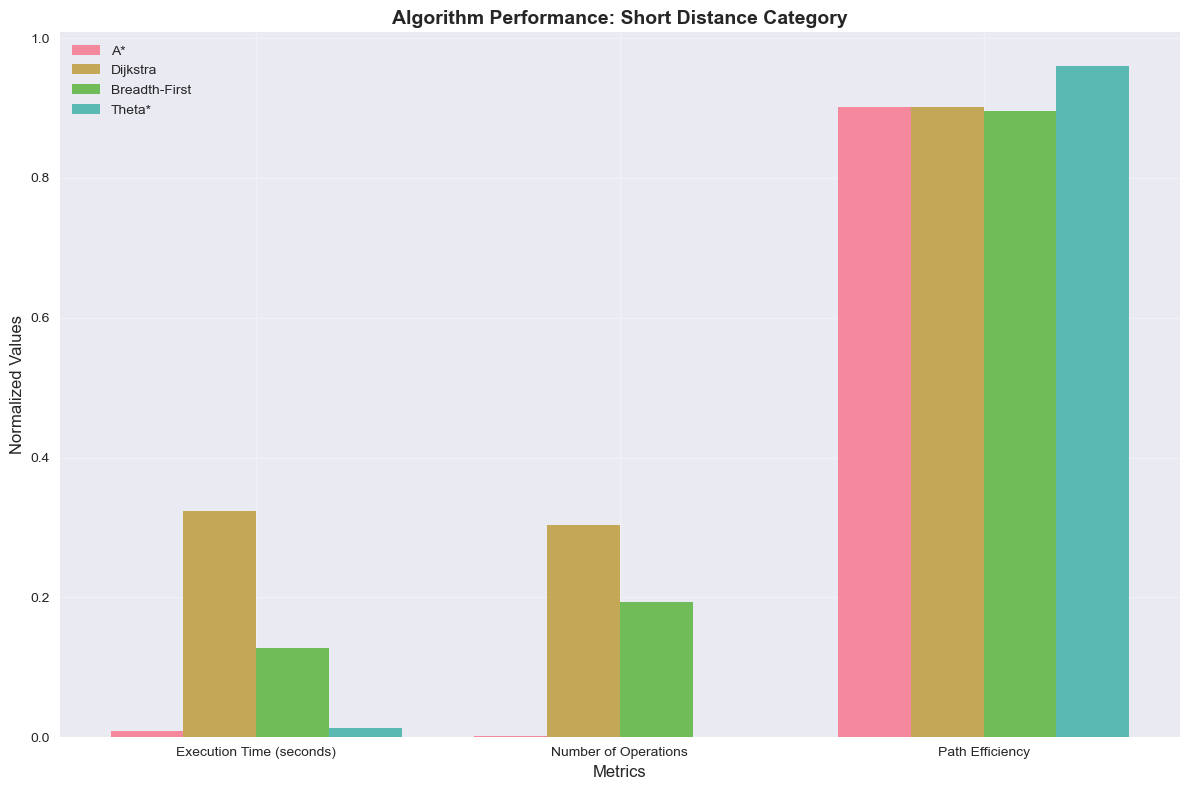

Saved: algorithm_analysis_plots_20250917_144437/08_distance_analysis_medium.png


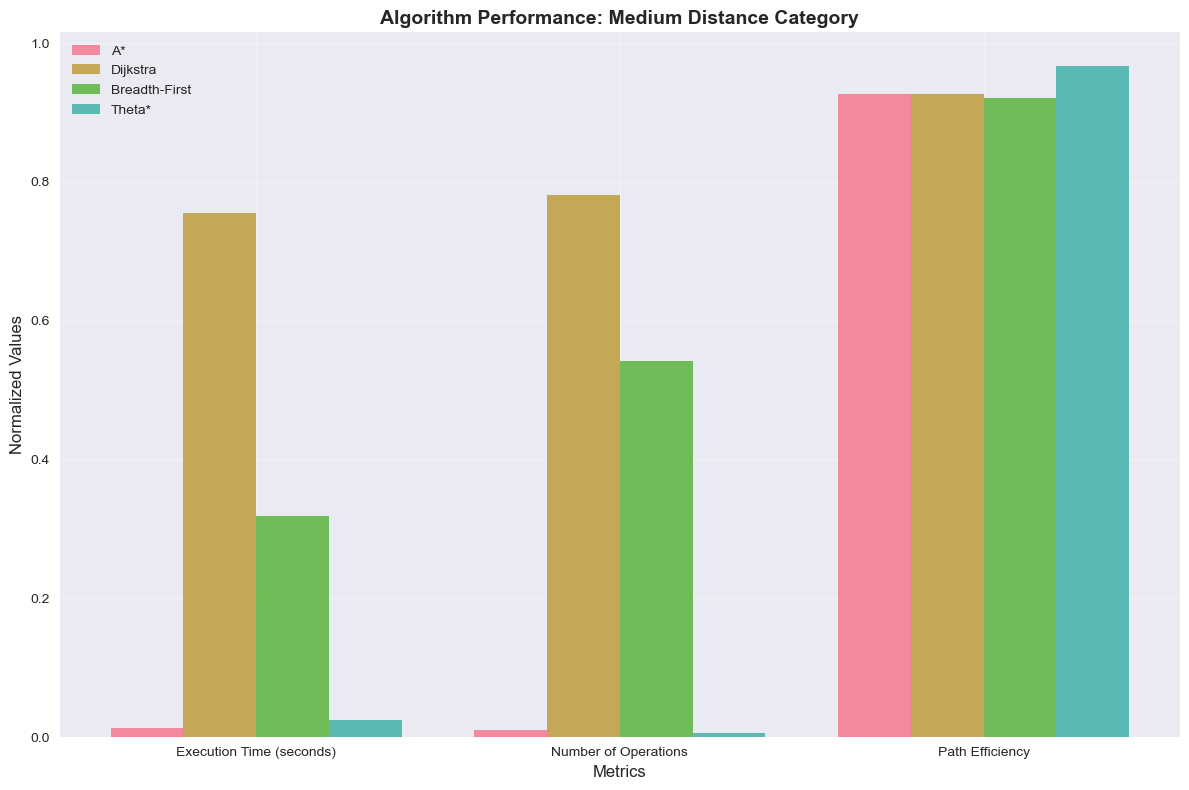

Saved: algorithm_analysis_plots_20250917_144437/08_distance_analysis_long.png


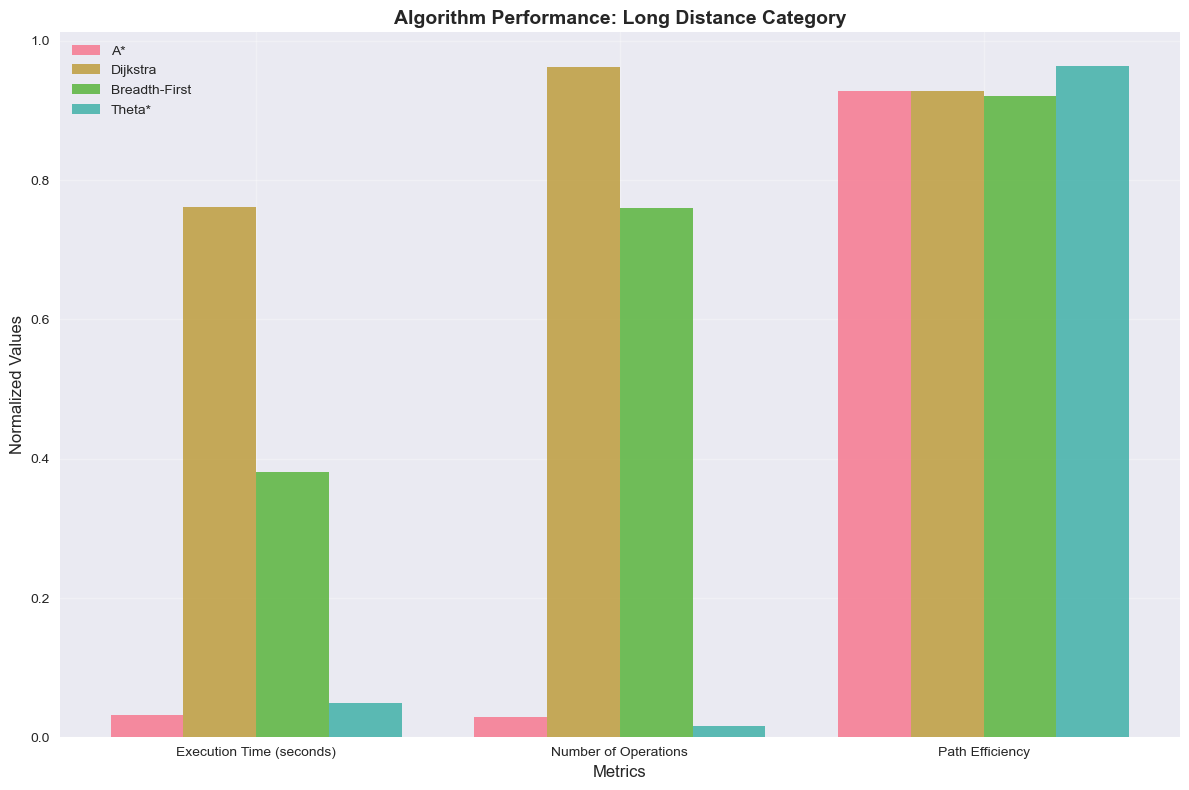

Saved: algorithm_analysis_plots_20250917_144437/08_distance_analysis_very_long.png


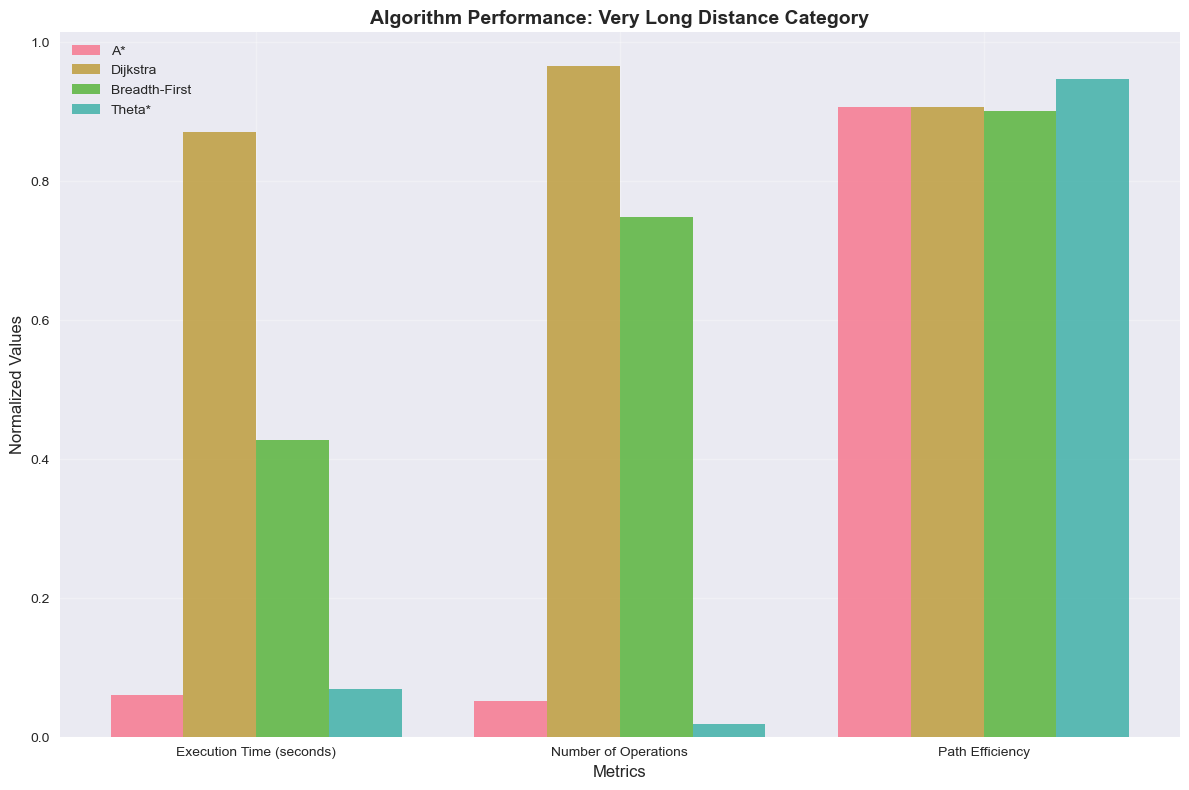

In [15]:
# Create individual distance-specific performance analysis plots
distance_categories = ['Short', 'Medium', 'Long', 'Very Long']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

for category, color in zip(distance_categories, colors):
    plt.figure(figsize=(12, 8))
    
    category_data = df[df['distance_category'] == category]
    
    # Create grouped bar chart for this distance category
    metrics_to_plot = ['execution_time', 'operations', 'path_efficiency']
    metric_titles = ['Execution Time (seconds)', 'Number of Operations', 'Path Efficiency']
    
    x = np.arange(len(metrics_to_plot))
    width = 0.2
    
    for j, algorithm in enumerate(df['algorithm'].unique()):
        algo_data = category_data[category_data['algorithm'] == algorithm]
        values = [algo_data[metric].mean() for metric in metrics_to_plot]
        
        # Normalize values for better comparison (except for path_efficiency)
        normalized_values = []
        for i, (metric, value) in enumerate(zip(metrics_to_plot, values)):
            if metric == 'path_efficiency':
                normalized_values.append(value)  # Keep as is for efficiency
            else:
                # Normalize by dividing by the maximum value in this category
                max_val = category_data[metric].max()
                normalized_values.append(value / max_val if max_val > 0 else 0)
        
        plt.bar(x + j*width, normalized_values, width, label=algorithm, alpha=0.8)
    
    plt.title(f'Algorithm Performance: {category} Distance Category', fontsize=14, fontweight='bold')
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.xticks(x + width * 1.5, metric_titles)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save the plot
    filename = f"08_distance_analysis_{category.lower().replace(' ', '_')}.png"
    save_plot(filename)
    plt.show()


## Key Findings and Conclusions


In [16]:
# Summary of saved plots
print("="*60)
print("PLOT SAVING SUMMARY")
print("="*60)
print(f"All plots have been saved to: {output_dir}")
print("\nFiles created:")
print("-" * 40)

# List all files in the output directory
if os.path.exists(output_dir):
    files = sorted(os.listdir(output_dir))
    for i, file in enumerate(files, 1):
        file_path = os.path.join(output_dir, file)
        file_size = os.path.getsize(file_path)
        print(f"{i:2d}. {file} ({file_size:,} bytes)")
    
    print(f"\nTotal files: {len(files)}")
    print(f"Directory: {os.path.abspath(output_dir)}")
else:
    print("Output directory not found!")

print("\n" + "="*60)
print("PLOT DESCRIPTIONS:")
print("="*60)
print("01_histogram_*.png     - Distribution histograms for each metric")
print("02_boxplot_*.png       - Box plots showing statistical distributions")
print("03_cdf_*.png           - Cumulative distribution functions")
print("04_distance_category_*.png - Performance by distance category")
print("05_correlation_matrix.png  - Correlation heatmap")
print("06_performance_summary.png - Algorithm performance comparison")
print("07_distance_specific_*.png - Distance-specific performance analysis")
print("08_distance_analysis_*.png - Detailed distance analysis")
print("="*60)


PLOT SAVING SUMMARY
All plots have been saved to: algorithm_analysis_plots_20250917_144437

Files created:
----------------------------------------
 1. 03_cdf_execution_time_astar_theta.png (170,131 bytes)
 2. 03_cdf_execution_time_bfs_dijkstra.png (184,755 bytes)
 3. 03_cdf_operations_astar_theta.png (157,940 bytes)
 4. 03_cdf_operations_bfs_dijkstra.png (188,277 bytes)
 5. 03_cdf_path_efficiency.png (216,397 bytes)
 6. 03_cdf_path_length.png (204,592 bytes)
 7. 03_violin_execution_time.png (235,657 bytes)
 8. 03_violin_operations.png (230,227 bytes)
 9. 03_violin_path_efficiency.png (276,000 bytes)
10. 03_violin_path_length.png (243,799 bytes)
11. 04_distance_category_execution_time.png (169,705 bytes)
12. 04_distance_category_operations.png (167,216 bytes)
13. 04_distance_category_path_efficiency.png (153,613 bytes)
14. 04_distance_category_path_length.png (151,292 bytes)
15. 05_correlation_matrix_astar.png (174,786 bytes)
16. 05_correlation_matrix_breadth_first.png (184,818 bytes)


In [17]:
print("=== KEY FINDINGS AND CONCLUSIONS ===\n")

# Calculate key insights
print("1. EXECUTION TIME ANALYSIS:")
exec_time_stats = df.groupby('algorithm')['execution_time'].agg(['mean', 'std', 'min', 'max'])
print(exec_time_stats.round(4))
fastest_algorithm = exec_time_stats['mean'].idxmin()
print(f"   Fastest algorithm: {fastest_algorithm} (avg: {exec_time_stats.loc[fastest_algorithm, 'mean']:.4f}s)")

print("\n2. OPERATIONS EFFICIENCY:")
ops_stats = df.groupby('algorithm')['operations'].agg(['mean', 'std'])
print(ops_stats.round(0))
most_efficient = ops_stats['mean'].idxmin()
print(f"   Most operationally efficient: {most_efficient} (avg: {ops_stats.loc[most_efficient, 'mean']:.0f} ops)")

print("\n3. PATH EFFICIENCY:")
efficiency_stats = df.groupby('algorithm')['path_efficiency'].agg(['mean', 'std'])
print(efficiency_stats.round(3))
most_efficient_path = efficiency_stats['mean'].idxmax()
print(f"   Most path efficient: {most_efficient_path} (avg: {efficiency_stats.loc[most_efficient_path, 'mean']:.3f})")

print("\n4. CONSISTENCY (Standard Deviation):")
print("   Execution Time Consistency:")
for algo in df['algorithm'].unique():
    cv = df[df['algorithm'] == algo]['execution_time'].std() / df[df['algorithm'] == algo]['execution_time'].mean() * 100
    print(f"   {algo}: CV = {cv:.1f}%")

print("\n5. DISTANCE CATEGORY PERFORMANCE:")
for category in ['Short', 'Medium', 'Long', 'Very Long']:
    print(f"\n   {category} Distance:")
    category_data = df[df['distance_category'] == category]
    best_time = category_data.groupby('algorithm')['execution_time'].mean().idxmin()
    best_efficiency = category_data.groupby('algorithm')['path_efficiency'].mean().idxmax()
    print(f"   Best execution time: {best_time}")
    print(f"   Best path efficiency: {best_efficiency}")

print("\n6. OVERALL RECOMMENDATION:")
print(f"   Based on the comprehensive analysis, {summary_df.index[0]} appears to be the best overall performer.")
print(f"   However, the choice of algorithm should depend on the specific requirements:")
print(f"   - For speed: {fastest_algorithm}")
print(f"   - For operational efficiency: {most_efficient}")
print(f"   - For path quality: {most_efficient_path}")


=== KEY FINDINGS AND CONCLUSIONS ===

1. EXECUTION TIME ANALYSIS:
                 mean     std     min     max
algorithm                                    
A*             0.0235  0.0322  0.0005  0.2211
Breadth-First  0.2746  0.1412  0.0194  0.6271
Dijkstra       0.5932  0.2663  0.0343  0.9941
Theta*         0.0326  0.0414  0.0024  0.2652
   Fastest algorithm: A* (avg: 0.0235s)

2. OPERATIONS EFFICIENCY:
                  mean      std
algorithm                      
A*              1533.0   2348.0
Breadth-First  39113.0  19663.0
Dijkstra       52634.0  24066.0
Theta*           729.0   1136.0
   Most operationally efficient: Theta* (avg: 729 ops)

3. PATH EFFICIENCY:
                mean    std
algorithm                  
A*             0.918  0.032
Breadth-First  0.912  0.035
Dijkstra       0.918  0.032
Theta*         0.961  0.028
   Most path efficient: Theta* (avg: 0.961)

4. CONSISTENCY (Standard Deviation):
   Execution Time Consistency:
   A*: CV = 137.3%
   Dijkstra: CV = 44.9%

# Pathfinding Algorithm Comparison Analysis

This notebook provides a comprehensive statistical analysis of different pathfinding algorithms (A*, Dijkstra, Breadth-First, Theta*) based on execution time, operations, path length, and path efficiency.

## Analysis includes:
- Descriptive statistics (mean, median, mode, standard deviation, variance)
- Distribution analysis (histograms, cumulative distribution functions)
- Performance comparison by distance categories (short, medium, long)
- Algorithm efficiency metrics
